Note that there is approximately around 15808 - 14563  = 1200 rows that have nan values that are incorrect.

In [4]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.stats
import scipy
import math
import random
from scipy.stats import binom_test
from scipy.stats import kstest
from scipy.stats import norm
import sys 
from scipy.stats import binom
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.stats import poisson
import random
import numpy as np
from numpy.random import random
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

In [5]:
def clopper_pearson(x, n, alpha=0.05):
    """Estimate the confidence interval for a sampled Bernoulli random
    variable.
    `x` is the number of successes and `n` is the number trials (x <=
    n). `alpha` is the confidence level (i.e., the true probability is
    inside the confidence interval with probability 1-alpha). The
    function returns a `(low, high)` pair of numbers indicating the
    interval on the probability.
    """
    
    b = scipy.stats.beta.ppf
    lo = b(alpha / 2, x, n - x + 1)
    hi = b(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi

In [6]:
class Model:
    def __init__(self):
        self.df = self.readindata() # processes our data into one dataframe
        self.cumprobdf = self.generatecumdata() # generates a cumulative probability dataframe
        self.binomialestimates = self.generatefinalbinomest() # returns final binomial estimates given observed all the data

    def readindata(self):
        df1 = pd.read_csv('combined.csv', sep = ';', header = None,on_bad_lines='skip',names = ['Link','a1','a2','a3','a4','a5','a6','a7','a8','a9','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19','a20','a21','a22','a23','a24','Date','a26'])
        df1 = df1.dropna(subset = 'Date')
        df2 = pd.read_csv('set2_combined.csv', sep = ';', header = None,on_bad_lines='skip',names = ['Link','b1','b2','b3','b4','b5','b6','b7','b8','b9','b10','b11','Date','b26'])
        df2 = df2.dropna(subset = 'Date')

        #Perform outer join
        df = pd.merge(df1,df2,how = 'outer')
        df['Date'] = [elem.split(sep='T')[0] for elem in df['Date']]
        df['Date'] = [datetime.strptime(elem,"%Y-%m-%d") for elem in df['Date']]
        #df['Date'] = [elem.strftime('%Y-%m') for elem in df['Date']]
        #Convert date format

        #Create a counter of the number of articles so when resampling, we attain the number of articles per day
        df['NumOfArticles'] = [1 for i in range(len(df['Date']))]

        #Drop columns a26 and b26 and the list of links
        del df['a26']
        del df['b26']
        del df['Link']

        #Set index to equal date and get rid of that column
        df.index = df['Date']
        del df['Date']

        #For each row, if the element appears in the article set equal to 1 else 0
        for column in list(df):
            df[column] = [1 if elem>0 else 0 for elem in df[column]]

        #Group by day
        df = df.resample('D').sum()

        #Select start and end dates
        df =df.loc['2022-02-02':'2023-2-10']
        print("Process our DataFrame:                   Successfully parsed and formatted our data")
        df.to_csv('./processeddata.csv')
        return(df) # returns processed dataframe

    def generatecumdata(self):
        #Create a dataframe that computes the cumulative probability up until that date of a keyword occuring
        cumprob = self.df.copy()

        #Generates cumulative sum
        for column in list(cumprob)[:-1]:
            cumprob[column] = [sum(cumprob[column][:i+1])/sum(cumprob['NumOfArticles'][:i+1]) for i in range(0,len(cumprob[column]))]
        cumprob['NumOfArticles'] =np.cumsum(cumprob['NumOfArticles'])

        #Compute Binomial Estimates
        binomestimates = [sum(self.df[column])/sum(self.df['NumOfArticles']) for column in list(self.df)[:-1]]

        #Check that estimates line up with cumulative probaiblities at the end of the dataframe
        for i in range(0,len(cumprob.iloc[-1][:-1])):
            if (cumprob.iloc[-1][:-1][i] != binomestimates[i]):
                print(False)
                break
            if i == len(cumprob.iloc[-1][:-1])-1:
                print("""Process our Cumulative Probabilities DataFrame:     TEST-
                    Binomial Probabilities is the same as last row of cumulative probabilities""")
                #If test completes successfully
        return(cumprob) # returns a dataframe containing cumulative probabilities
        
    def generatefinalbinomest(self):
        return([sum(self.df[column])/sum(self.df['NumOfArticles']) for column in list(self.df)[:-1]])
    
    def MA_mean_df(self,K):
        #Generate moving average of observations
        movingaveragedf = self.df.copy()
        return(pd.DataFrame(self.df).rolling(K,center = True)).mean()

    def MA_sd_df(self,K):
        #Generate moving average of standard deviations
        movingsddf = self.df.copy()
        return(pd.DataFrame(self.df).rolling(K,center=True).std())

    def MA_binomest_CI_plot(self,column= None, K=30,alpha=0.05):
        #Generates plot for a given column
        rollingbinomestimatesdf = self.cumprobdf

        rolling_binom_estimate = list(rollingbinomestimatesdf[column])

        CI_lower = []
        CI_upper = []

        for k in range(len(rolling_binom_estimate)):
            total = list(self.cumprobdf['NumOfArticles'])[k]
            successes = total*rolling_binom_estimate[k]
            lo, hi = clopper_pearson(successes, total)
            CI_lower.append(lo)
            CI_upper.append(hi)
        
        figure(figsize=(10, 10), dpi=160)
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        #Plot binomestiamtes
        ax1.plot(self.df.index.values, rolling_binom_estimate, label = "line 1")
        #Plot upper and lower CI
        ax1.plot(self.df.index.values,CI_lower , label = "line 2")
        ax1.plot(self.df.index.values,CI_upper , label = "line 3")
        #Plot mean of our data
        ax2.bar(self.df.index.values, self.MA_mean_df(30)[column] ,width = 0.3)
        plt.show()
    
    def CI_of_estimates_plot(self):
        lot = []
        hit = []
        # For each of the final binomial estimates
        for prob in self.binomialestimates:
            successes = prob*self.cumprobdf['NumOfArticles'][-1]
            total = self.cumprobdf['NumOfArticles'][-1]
            lo, hi = clopper_pearson(successes, total)
            lot.append(lo)
            hit.append(hi)

        y=[]
        for i in range(len(self.binomialestimates)):
            y.append((lot[i],hit[i]))
        x = [i for i in range(len(self.binomialestimates))]
        plt.scatter(x,self.binomialestimates, s = 4)
        plt.plot((x,x),([i for (i,j) in y], [j for (i,j) in y]),c='black')
        plt.xlabel("Category")
        plt.ylabel('Probability')
        plt.show()
        #remember to define p first!

    #remember to define p first!

    def binplot2(self):
        columns = list(self.df)[0:-1]
        k = 0 
        column = columns
        for column in columns:
            #Set up plots with two axis
            fig, ax1 = plt.subplots()
            ax2 = ax1.twinx()
            #Compute histogram with weights i.e. the pdf
            #weights = np.ones_like(self.df[column]) / list(self.cumprobdf["NumOfArticles"])[-1]
            labels, counts = np.unique(self.df[column], return_counts=True)
            counts = counts/list(self.cumprobdf["NumOfArticles"])[-1]
            ax1.bar(labels, counts, align='center',width = 0.4,alpha = 0.7)
            #ax1.gca().set_xticks(labels)
            #ax1.hist(self.df[column], weights=weights, align = 'center')

            #Compute the binomial pdf
            p_hat = np.mean(self.df[column])/list(self.df["NumOfArticles"])[-1]
            # n is fixed
            n = list(self.df["NumOfArticles"])[-1]
            # defining list of r values
            r_values = list(range(0,max(self.df[column])+1))
            # list of pmf values
            dist = [binom.pmf(r, n, p_hat) for r in r_values ]
            # plotting the graphs
            ax2.plot(r_values, dist,"r-")
            
            ax1.set_title(column)
            ax1.set_ylabel("Histogram Density")
            ax2.set_ylabel("Probability Density")
            ax1_ylims = ax1.axes.get_ylim()           # Find y-axis limits set by the plotter
            ax1_yratio = ax1_ylims[0] / ax1_ylims[1]  # Calculate ratio of lowest limit to highest limit

            ax2_ylims = ax2.axes.get_ylim()           # Find y-axis limits set by the plotter
            ax2_yratio = ax2_ylims[0] / ax2_ylims[1]  # Calculate ratio of lowest limit to highest limit


            # If the plot limits ratio of plot 1 is smaller than plot 2, the first data set has
            # a wider range range than the second data set. Calculate a new low limit for the
            # second data set to obtain a similar ratio to the first data set.
            # Else, do it the other way around

            if ax1_yratio < ax2_yratio: 
                ax2.set_ylim(bottom = ax2_ylims[1]*ax1_yratio)
            else:
                ax1.set_ylim(bottom = ax1_ylims[1]*ax2_yratio)

            plt.tight_layout()
            plt.show()

Process our DataFrame:                   Successfully parsed and formatted our data
Process our Cumulative Probabilities DataFrame:     TEST-
                    Binomial Probabilities is the same as last row of cumulative probabilities


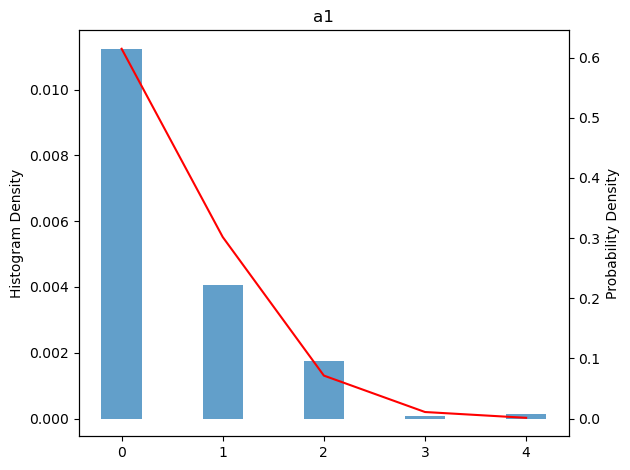

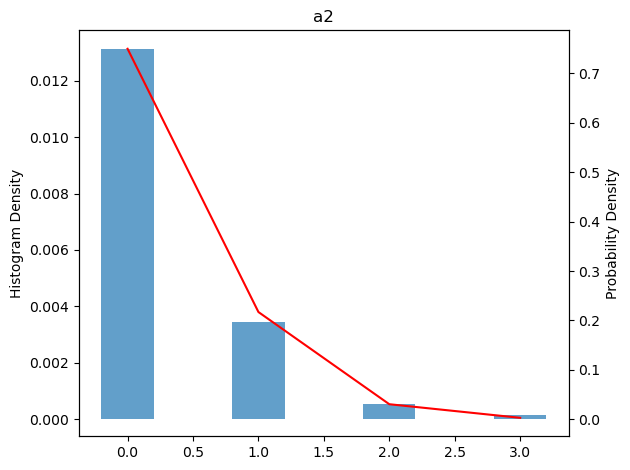

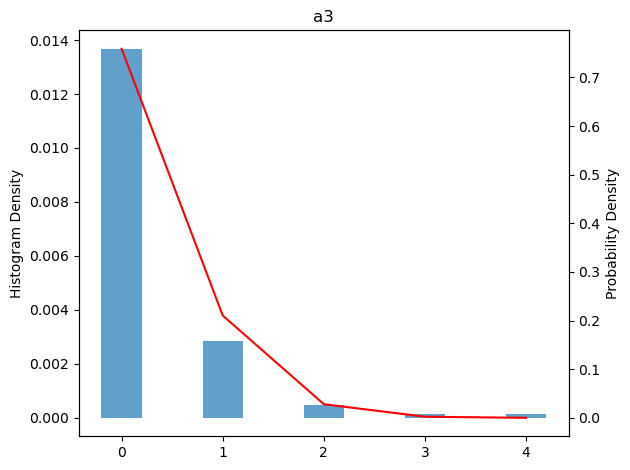

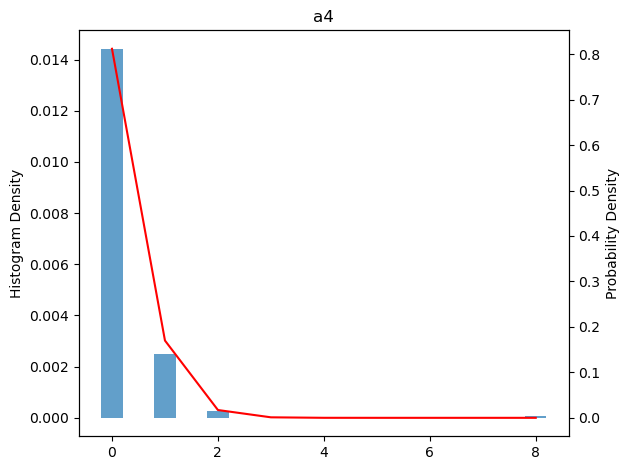

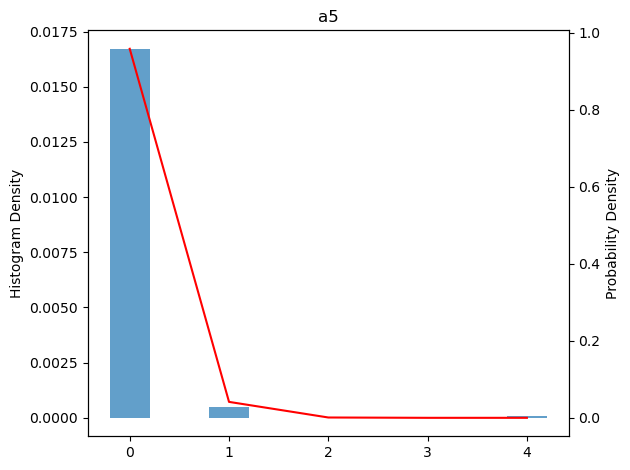

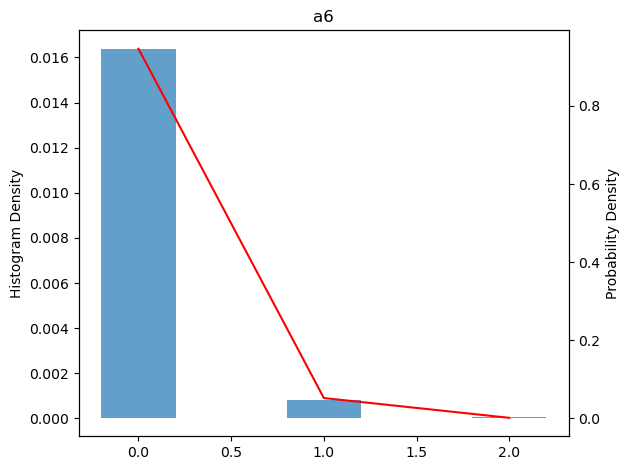

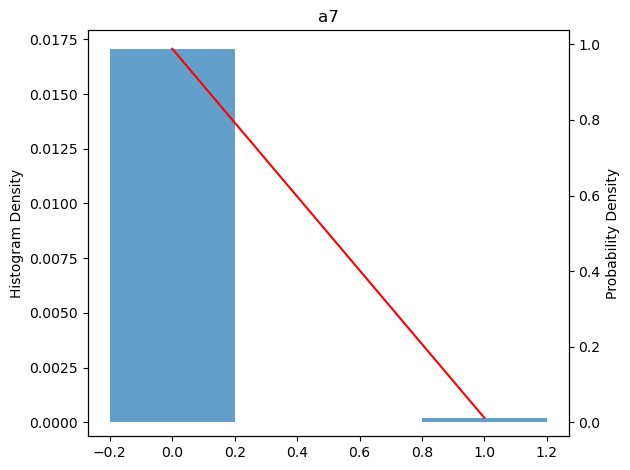

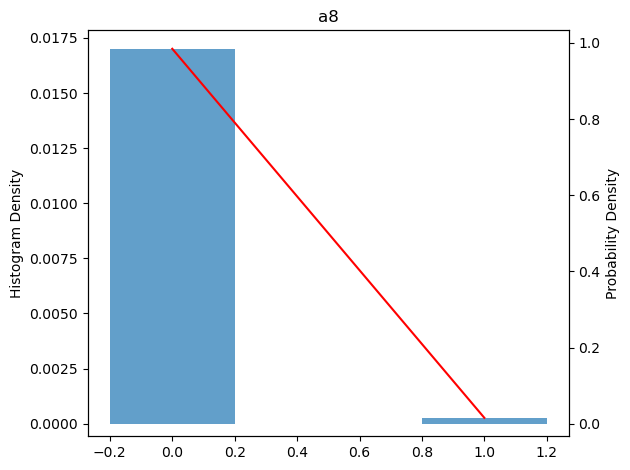

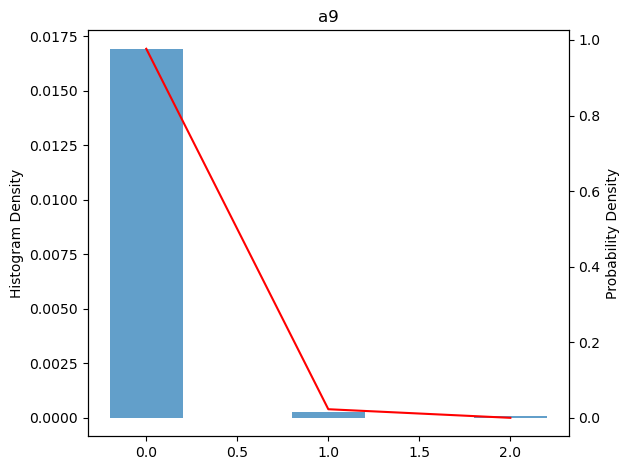

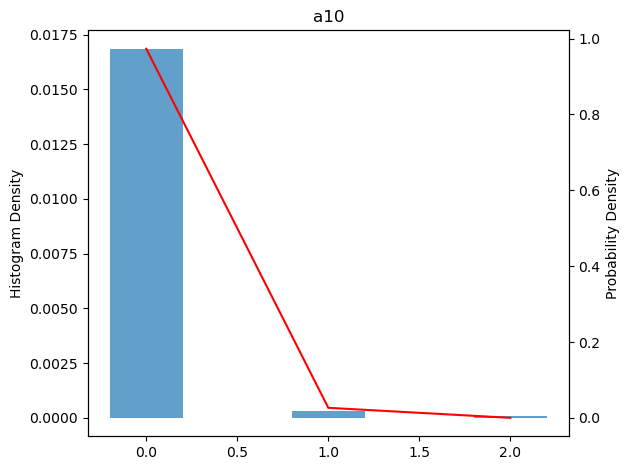

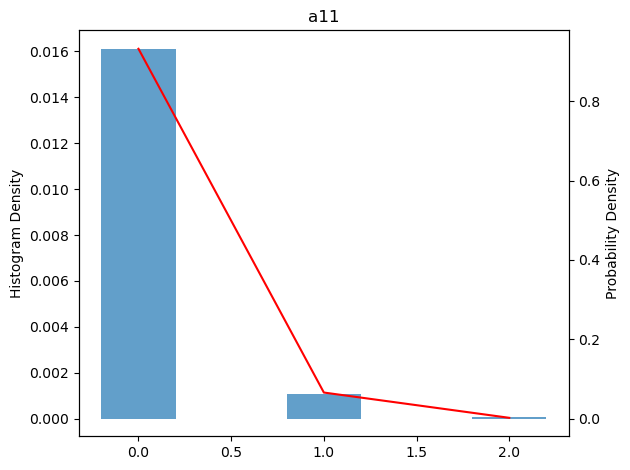

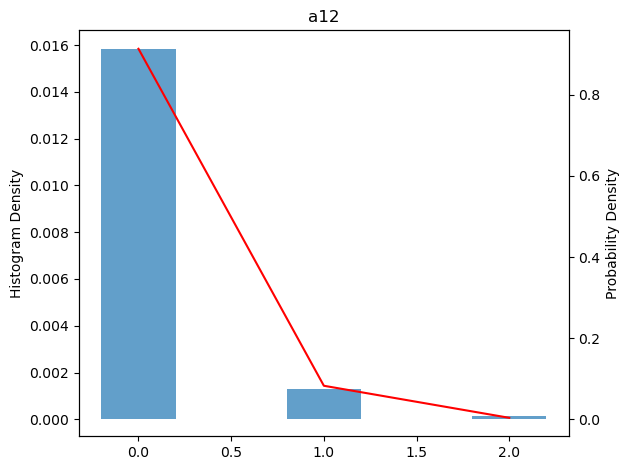

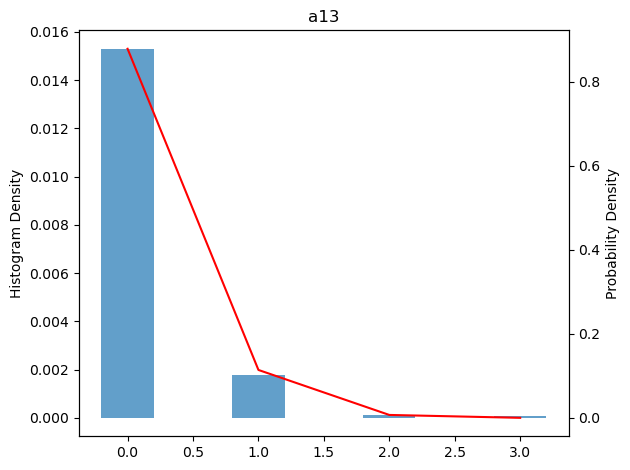

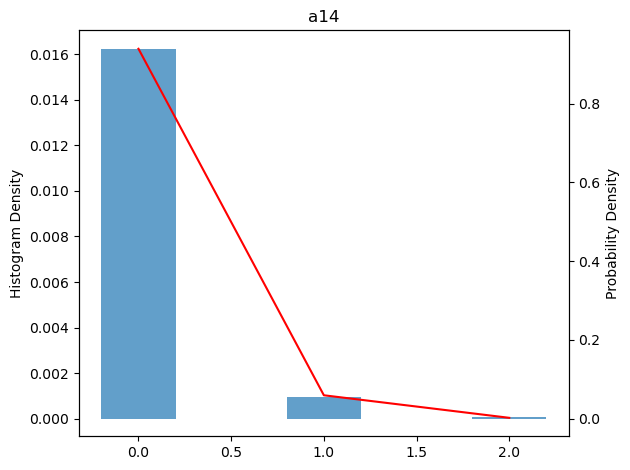

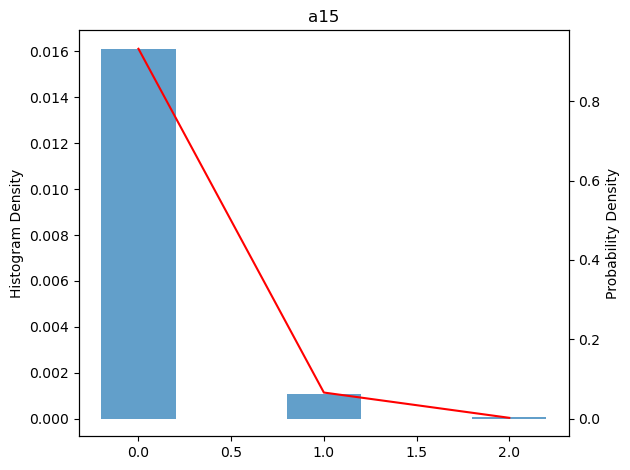

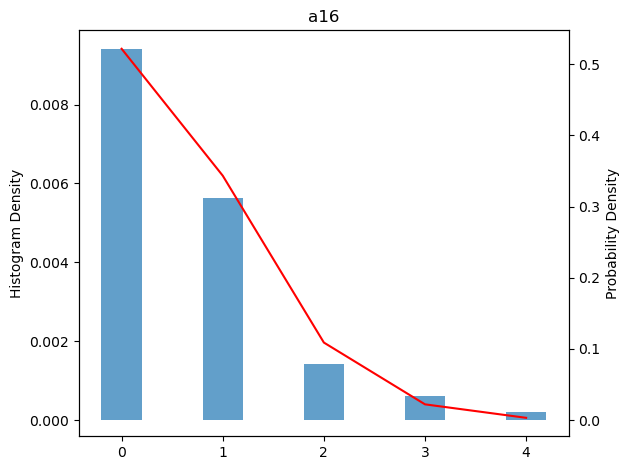

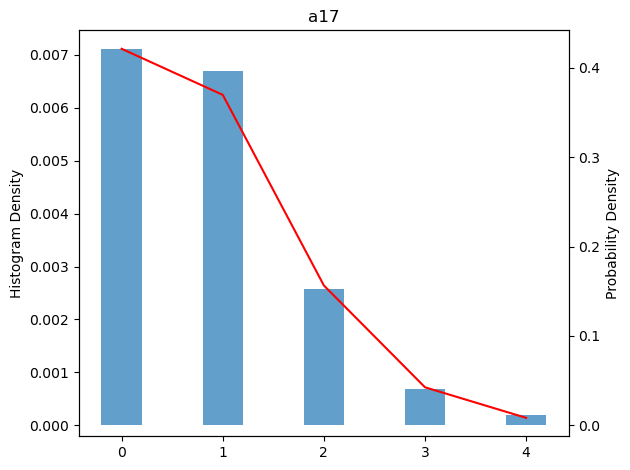

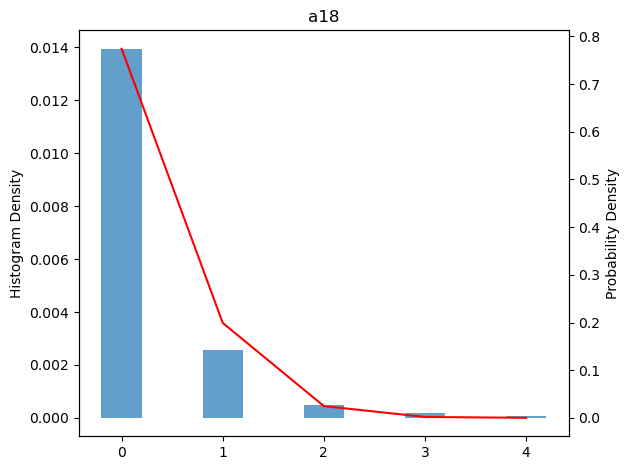

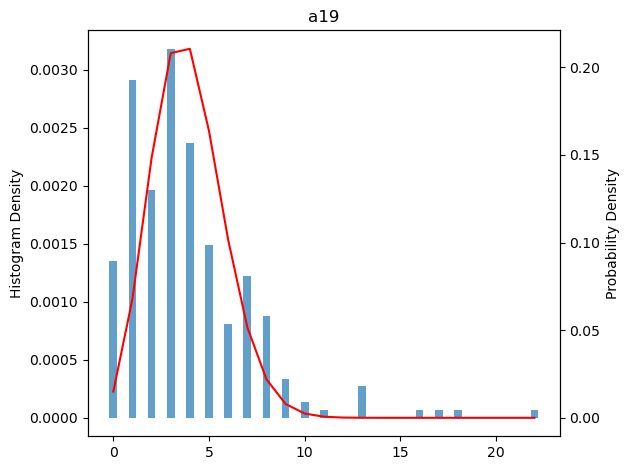

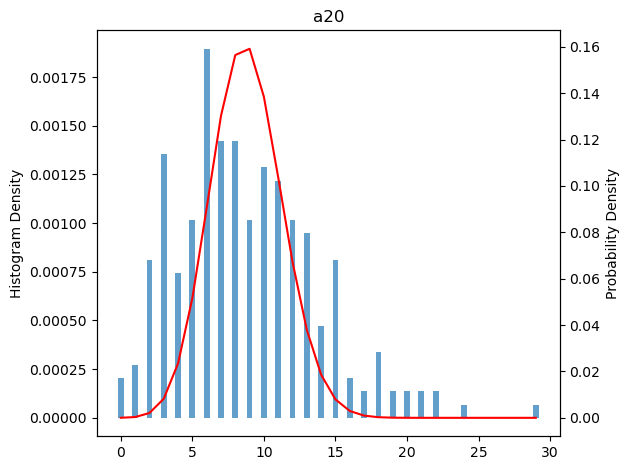

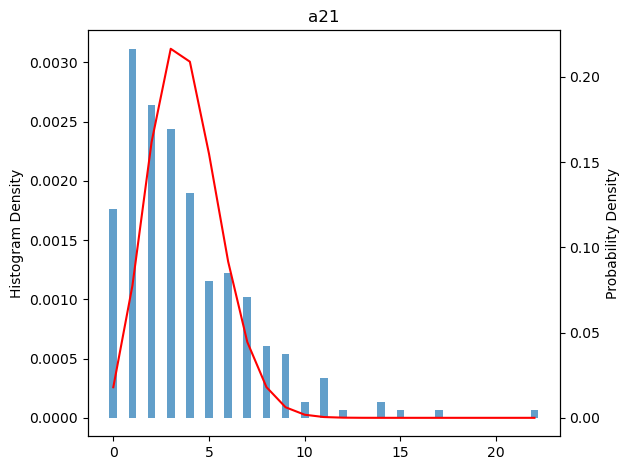

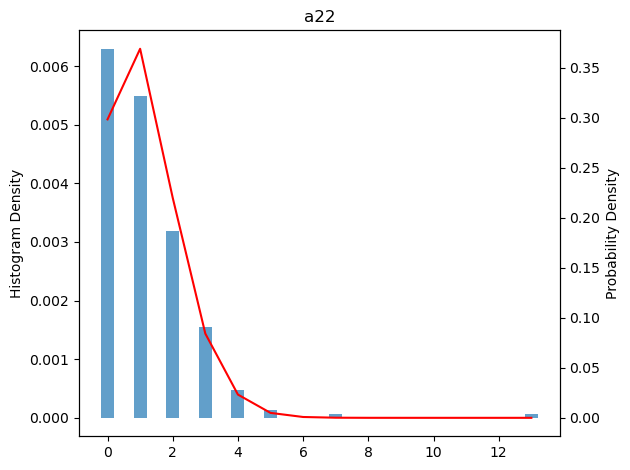

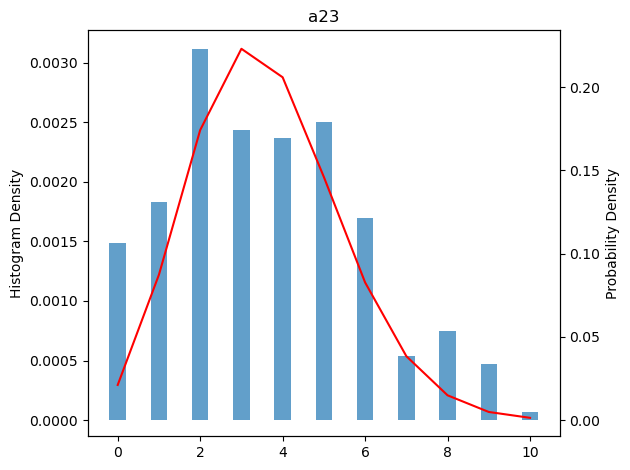

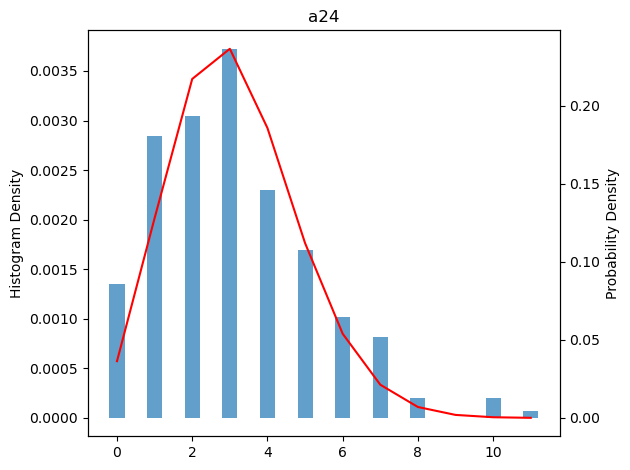

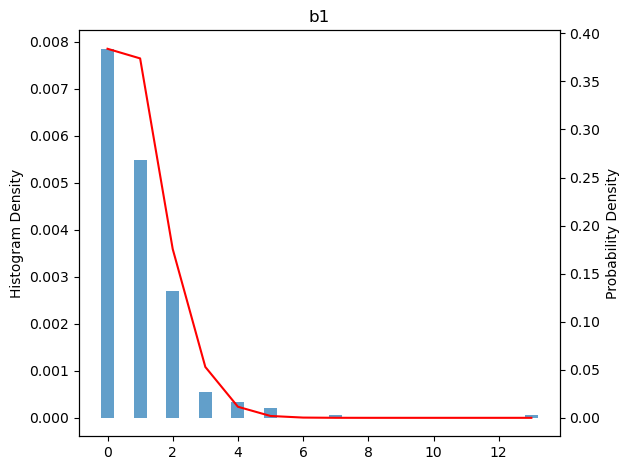

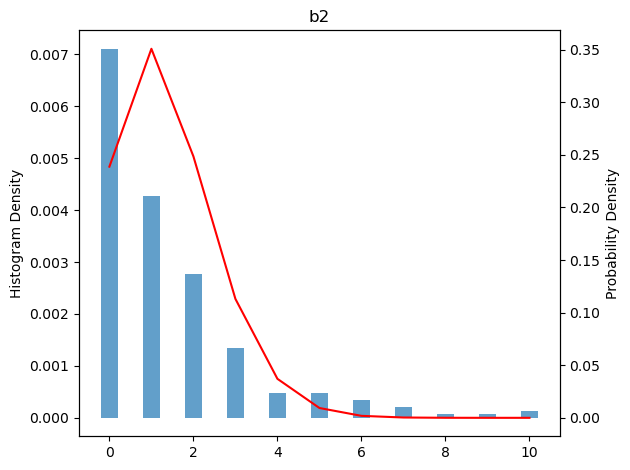

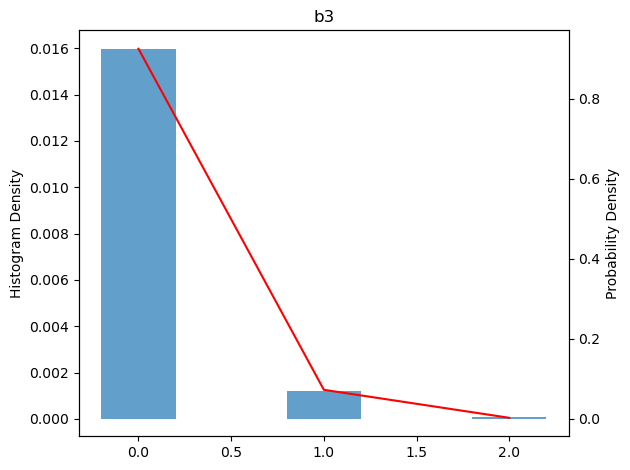

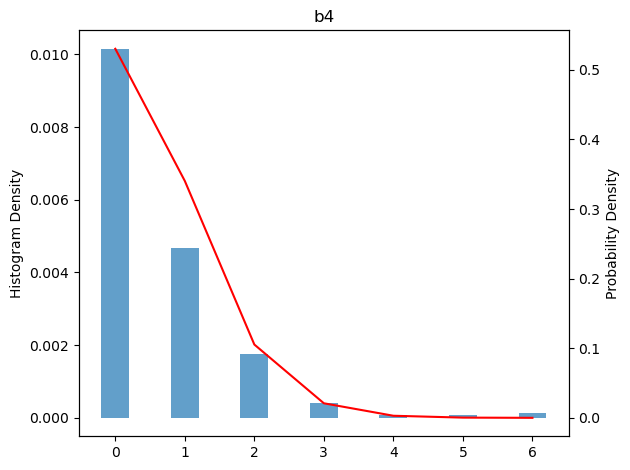

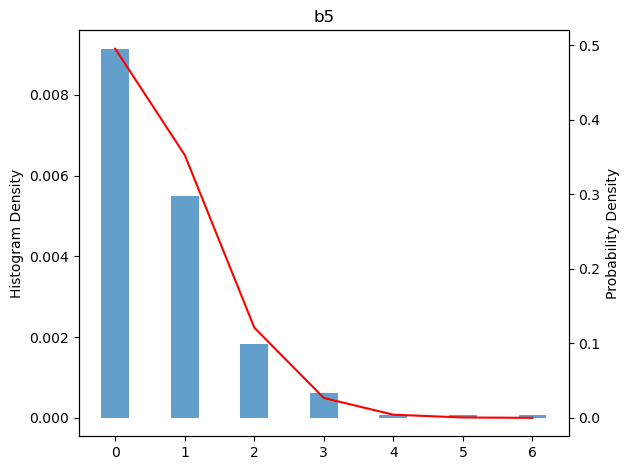

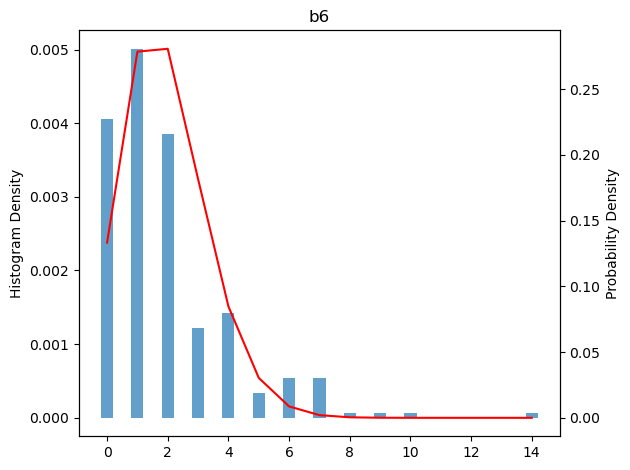

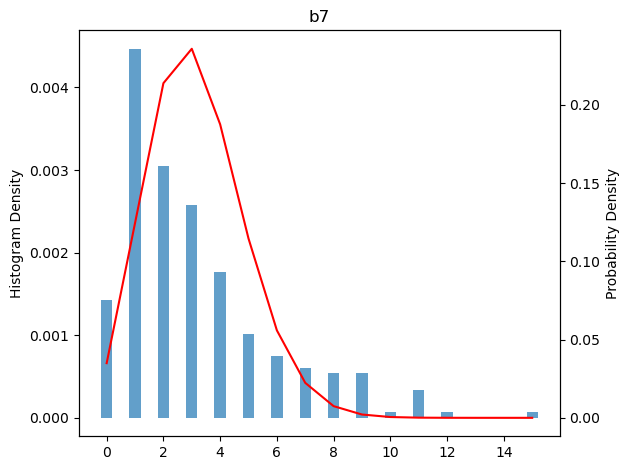

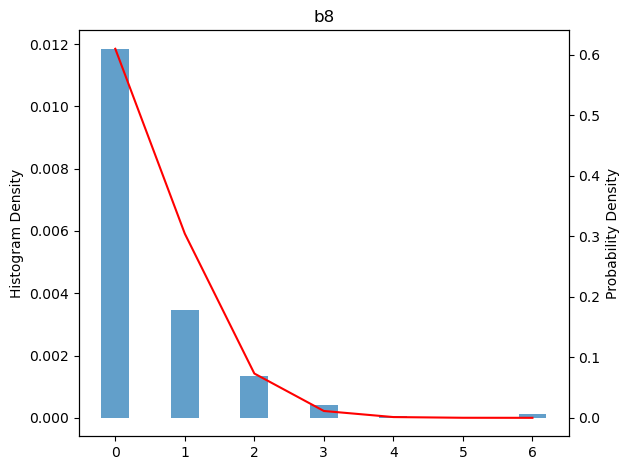

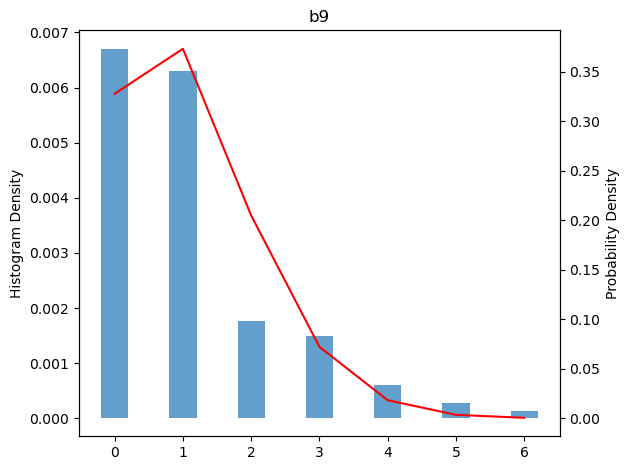

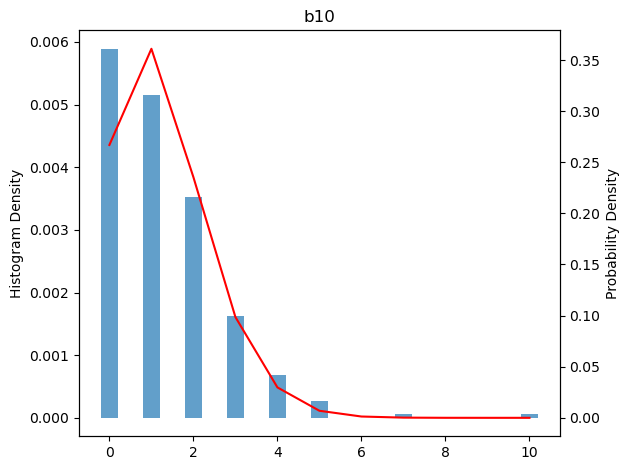

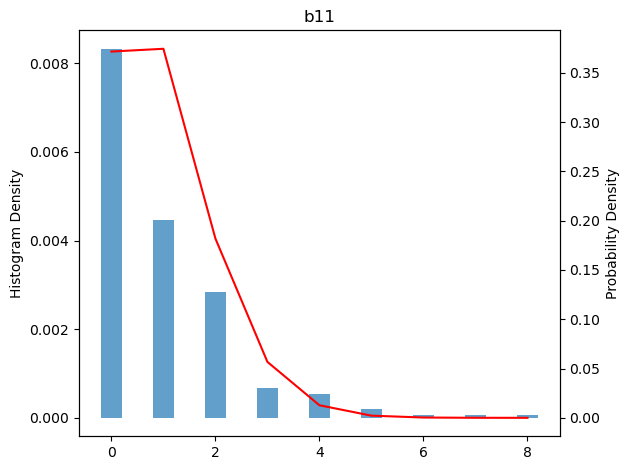

In [7]:
analysis3 = Model()
analysis3.binplot2()

In [6]:
import tokenize
fileObj = open('mainpy.py', 'r')
for toktype, tok, start, end, line in tokenize.generate_tokens(fileObj.readline):
    if toktype == tokenize.COMMENT:
        print(tok)

# %% [markdown]
# Note that there is approximately around 15808 - 14563  = 1200 rows that have nan values that are incorrect.
# %% [markdown]
# 
# %%
# %%
# %%
# processes our data into one dataframe
# generates a cumulative probability dataframe
# returns final binomial estimates given observed all the data
#Perform outer join
#df['Date'] = [elem.strftime('%Y-%m') for elem in df['Date']]
#Convert date format
#Create a counter of the number of articles so when resampling, we attain the number of articles per day
#Drop columns a26 and b26 and the list of links
#Set index to equal date and get rid of that column
#For each row, if the element appears in the article set equal to 1 else 0
#Group by day
#Select start and end dates
# returns processed dataframe
#Create a dataframe that computes the cumulative probability up until that date of a keyword occuring
#Generates cumulative sum
#Compute Binomial Estimates
#Check that estimates line up with cumulative probaiblities at the end of the d

TIME STEP START FROM 1 FOR SIMULATIONS!

In [66]:
class MonteCarlo:
    def __init__(self,analysis):
        self.hi = 2
        self.df = analysis.df
        self.analysis = analysis
        self.SMCstates = {}


    # state space model - Mutation
    def StateSpace_iplus1(self,xt):
        return(xt*np.random.uniform(low = 0.8, high = 1.2))
        #return(Xt_1 *dnp.random.lognormal(mean=0.0, sigma=1.0)
        #return(Xt_1*np.random.exponential(scale = 1))

    #Conditional probability of Xt given Xt+1
    def backwardkernelfunc(self,xt,xt_1):
        return(scipy.stats.uniform.pdf(xt_1/xt,loc = 0.8,scale = 0.4))

    
    #Mutation
    def hiddenmodel_iplus1(self,observation,state):
        return(poisson.pmf(observation, mu=state))

    def general_filter(self,obs,N):
        ParticleStates = [0 for z in range(len(obs))]
        # N is the number of particles for filter
        # oba is our observation vector
        obs = np.array(obs)

        # Initial prior distribution for our unobservable quantity of interest
        initialstate = [np.mean(obs) for i in range(0,N)]
        X = initialstate
        ParticleStates[0] = initialstate
        #Store the final rate paramater
        rate =np.zeros(len(obs))

        for i in range(0,len(obs)):
            #Give the parameter for our state space model and updated rate 
            # having ovserved our data point Y[i]
            [X,X_est] = self.Filter(X,obs[i],N)
            ParticleStates[i] = X
            rate[i] = X_est
        return(rate,ParticleStates)

    def Filter(self,Particles,Yobs,N):
        Weights = [0 for i in range(N)]
        #For each particle in our filter

        #Draw a sample from our 'proposal distribution' i.e. for computing predictive step
        for i in range(0,N):
            #Mutate firstly
            
            Particles[i] = self.StateSpace_iplus1(Particles[i])
            #Compute weights by computing the current likelihood of a particle
            Weights[i] = self.hiddenmodel_iplus1(Yobs,Particles[i])

        #Normalise weights
        sumW = sum(Weights)
        for i in range(N):
            Weights[i] = Weights[i]/sumW
            
        #Resample from these weights    

        Particles = np.random.choice(Particles,replace = True, size = N, p = Weights)
        
        #Convert to state space vectors
        Particles_est = sum(Particles)/N
        return(Particles,Particles_est)    

    def movingaveragemontecarlo(self,ID,K,N):
        p_est_dict = {}
        vals = self.df[ID]
        df_dummy = self.df.copy()
        [rate,ParticleStates] = self.general_filter(self.df[ID],N)
        self.SMCstates[ID] = ParticleStates
        
        #dfp.rolling(7, center=True).mean()
        hi = pd.DataFrame(vals)
        dude = pd.DataFrame(hi).rolling(K, center=True).mean()        
        
        df_dummy['Plottingrate'] = rate
        
        figure(figsize=(10, 20), dpi=320)
        fig, ax = plt.subplots()
        plt.plot(self.df.index.values,df_dummy['Plottingrate'], color = 'red')
        ax.bar(self.df.index.values, dude[ID] ,width = 0.3)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Only plot the month
        plt.title(ID)
        plt.savefig('./Plots/SMC/'+ID)
        plt.show()


    def general_smoother_filter(self,obs,N,ParticleStates):
        SmoothedParticleStates = [0 for z in range(len(obs))]
        # N is the number of particles for filter
        # oba is our observation vector
        obs = np.array(obs)

        # Initial prior distribution for our unobservable quantity of interest
        initialstate = [np.mean(obs) for i in range(0,N)]
        X = initialstate
        X_est = np.mean(X)
        SmoothedParticleStates[0] = initialstate
        #Store the final rate paramater
        rate =np.zeros(len(obs))

        for t in range(1,len(obs)):
            #Give the parameter for our state space model and updated rate 
            # having ovserved our data point Y[i]
            [X,X_est] = self.SmoothFilter(ParticleStates,X_est,N,t)
            SmoothedParticleStates[t] = X
            rate[t] = X_est
        return(rate,SmoothedParticleStates)

    def SmoothFilter(self,ParticleStates,prevstate,N,time):
        Resampled_particles = [0 for i in range(N)]
        #For each particle in our filter

        #Draw a sample from our 'proposal distribution' i.e. for computing predictive step
        for i in range(0,N):
            states_of_i_particle_over_time = [ParticleStates[j][i] for j in range(0,time)]
        
        new_states = np.random.choice(states_of_i_particle_over_time.append(self.StateSpace_iplus1(prevstate)))
        new_states_est = np.mean(new_states)

        return(new_states,new_states_est)    

    def smoothing(self,obs,N):
        X0 = [np.mean(obs) for i in range(N)]
        W0 = [self.hiddenmodel_iplus1(obs[0],X0[i]) for i in range(N)]
        sumW = sum(W0)
        for i in range(N):
            W0[i] = W0[i]/sumW
        
        # for t in range(1,len(obs)):
    
    def saveStates(self):
        # load csv module
        import csv

        # define a dictionary with key value pairs
        dict = self.SMCstates

        # open file for writing, "w" is writing
        w = csv.writer(open("States.csv", "w"))

        # loop over dictionary keys and values
        for key, val in dict.items():

            # write every key and value to file
            w.writerow([key, val])

    def smc_smoothing(self, num_particles, observations, transition_kernel, observation_kernel, num_steps):
        # Initialize the particles and their weights
        particles = np.zeros((num_steps, num_particles))
        particles[0, :] = np.random.rand(num_particles)
        weights = np.ones((num_steps, num_particles)) / num_particles

        for step in range(1, num_steps):
            # Propagate the particles through the transition kernel
            for i in range(num_particles):
                particles[step, i] = transition_kernel(particles[step-1, i])

            # Calculate the weights based on the observations and observation kernel
            weights[step, :] = observation_kernel(observations[step], particles[step, :])
            weights[step, :] = weights[step, :] / sum(weights[step, :])

            # Resample the particles according to their weights
            indices = np.random.choice(range(num_particles), size=num_particles, p=weights[step, :])
            particles[step, :] = particles[step, indices]
            weights[step, :] = np.ones(num_particles) / num_particles

        # Calculate the smoothed particles and weights
        smoothed_particles = np.zeros((num_steps, num_particles))
        smoothed_weights = np.zeros((num_steps, num_particles))
        for step in range(num_steps-1, -1, -1):
            # Calculate the smoothed weights
            print(step+1)
            smoothed_weights[step, :] = (weights[step, :] *
                                        np.dot(transition_kernel(particles[step, :]), smoothed_weights[step+1, :]))
            smoothed_weights[step, :] = smoothed_weights[step, :] / sum(smoothed_weights[step, :])

            # Calculate the smoothed particles
            smoothed_particles[step, :] = np.dot(smoothed_weights[step, :], particles[step, :])
        return smoothed_particles, smoothed_weights

    def smc_smoother(self,num_particles, observations, transition_kernel, observation_kernel, num_steps):
        # Initialize the particles and their weights
        particles = np.zeros((num_steps, num_particles))
        particles[0, :] = np.random.rand(num_particles)
        weights = np.ones((num_steps, num_particles)) / num_particles

        for step in range(1, num_steps):
            # Propagate the particles through the transition kernel
            for i in range(num_particles):
                particles[step, i] = transition_kernel(particles[step-1, i])

            # Calculate the weights based on the observations and observation kernel
            for i in range(0, num_particles):
                weights[step, i] = observation_kernel(observations[step], particles[step, i])
            weights[step, :] = weights[step, :] / sum(weights[step, :])

            # Resample the particles according to their weights
            indices = np.random.choice(range(num_particles), size=num_particles, p=weights[step, :])
            particles[step, :] = particles[step, indices]
            weights[step, :] = np.ones(num_particles) / num_particles

        # The smoother estimate at each time step is calculated as a weighted average of particles at all future time steps
        smoothed_estimate = np.zeros((num_steps, num_particles))
        smoothed_estimate[-1, :] = particles[-1, :]
        for step in range(num_steps-2, -1, -1):
            # Calculate the backward kernel, which is the conditional probability of a particle at time t given a particle at time t+1
            backward_kernel = np.zeros((num_particles, num_particles))
            for i in range(num_particles):
                for j in range(num_particles):
                    backward_kernel[i, j] = self.backwardkernelfunc(particles[step+1, j], particles[step, i])

            # Calculate the smoothed weights as the product of the forward and backward kernels
            smoothed_weights = np.zeros((num_particles, num_particles))
            for i in range(num_particles):
                for j in range(num_particles):
                    smoothed_weights[i, j] = weights[step, i] * backward_kernel[i, j] / np.dot(backward_kernel[:, j], weights[step, :])

            # The smoothed estimate at time t is a weighted average of the particles at time t+1
            smoothed_estimate[step, :] = np.dot(smoothed_weights, smoothed_estimate[step+1, :])

        return smoothed_estimate

In [62]:
Hello = MonteCarlo(analysis3)
[a,states] = Hello.general_filter(analysis3.df['a23'],110)



In [67]:
Hello.general_smoother_filter(obs = analysis3.df['a23'],N = 100, ParticleStates= states)

ValueError: a must be 1-dimensional or an integer

In [ ]:
4.00118936, 3.56475054, 4.02264832, 3.2153699 , 3.76145537,
       3.1426831 , 3.37277806, 3.50715877, 2.72544764, 2.55206073,
       3.38440022, 3.61817475, 3.24642849, 4.42006335, 4.30849244,
       4.40073753, 2.60147102, 3.56872025

In [54]:
states

[array([4.00118936, 3.56475054, 4.02264832, 3.2153699 , 3.76145537,
        3.1426831 , 3.37277806, 3.50715877, 2.72544764, 2.55206073,
        3.38440022, 3.61817475, 3.24642849, 4.42006335, 4.30849244,
        4.40073753, 2.60147102, 3.56872025, 4.55758849, 3.48794395,
        4.40025943, 3.71939818, 4.42015418, 2.95081682, 3.62255573,
        3.12093599, 4.68540917, 4.01733507, 3.14803014, 4.18653506,
        2.7667024 , 3.74707887, 3.58549479, 3.93048722, 3.30707078,
        2.87816655, 3.50866002, 4.06779193, 3.76643871, 3.78400974,
        3.74948778, 2.64404331, 3.74133732, 3.9273064 , 4.58471703,
        3.52215121, 3.03730203, 3.37833741, 3.75606776, 4.05773145,
        3.37191797, 3.0262053 , 4.44208914, 3.34829452, 2.75455643,
        3.77227655, 3.70948893, 3.59299959, 3.49367109, 2.80740003,
        4.08862691, 3.29943642, 3.65007556, 3.80399568, 3.98769465,
        3.13725745, 3.64718797, 3.41222047, 3.13514024, 3.73420081,
        3.00771421, 3.66394458, 3.35648908, 3.54

Iteration:      1,   Func. Count:     33,   Neg. LLF: 711.4485454331788
Iteration:      2,   Func. Count:     66,   Neg. LLF: 711.1000471875153
Iteration:      3,   Func. Count:     99,   Neg. LLF: 758.599213017705
Iteration:      4,   Func. Count:    132,   Neg. LLF: 767.4689703796323
Iteration:      5,   Func. Count:    165,   Neg. LLF: 734.4564227131702
Iteration:      6,   Func. Count:    198,   Neg. LLF: 711.4556608964708
Iteration:      7,   Func. Count:    231,   Neg. LLF: 731.4439938247137
Iteration:      8,   Func. Count:    264,   Neg. LLF: 779.6703030496539
Iteration:      9,   Func. Count:    297,   Neg. LLF: 717.883636861805
Iteration:     10,   Func. Count:    330,   Neg. LLF: 697.9164103961878
Iteration:     11,   Func. Count:    363,   Neg. LLF: 694.8322214507596
Iteration:     12,   Func. Count:    395,   Neg. LLF: 695.2890490057468
Iteration:     13,   Func. Count:    428,   Neg. LLF: 695.3992073402679
Iteration:     14,   Func. Count:    461,   Neg. LLF: 693.50224522

C:\Users\kianv\AppData\Roaming\Python\Python39\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


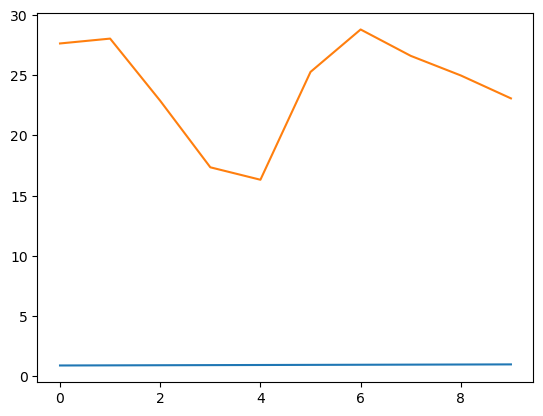

In [27]:
# example of ARCH model
from random import gauss
from random import seed
from matplotlib import pyplot
from arch import arch_model

data = [float(x) for x in analysis3.df['a23'].values.tolist()]
# split into train/test
n_test = 10
train, test = data[:-n_test], data[-n_test:]
# define model
model = arch_model(train, mean='Zero', vol='GARCH', p=15, q=15)
# fit model
model_fit = model.fit()
# forecast the test set
yhat = model_fit.forecast(horizon=n_test)
# plot the actual variance
var = [i*0.01 for i in range(0,100)]
pyplot.plot(var[-n_test:])
# plot forecast variance
pyplot.plot(yhat.variance.values[-1, :])
pyplot.show()

In [22]:
import pandas as pd
from arch import arch_model

# Load the data into a pandas dataframe
df = analysis3.df

# Define the GARCH model
garch_model = arch_model(df["a23"].values, mean="Zero", vol="GARCH", p=1, q=1)

# Fit the model to the data
garch_results = garch_model.fit()

# Print the summary of the fitted model
print(garch_results.summary())


ValueError: Buffer dtype mismatch, expected 'double' but got 'long long'

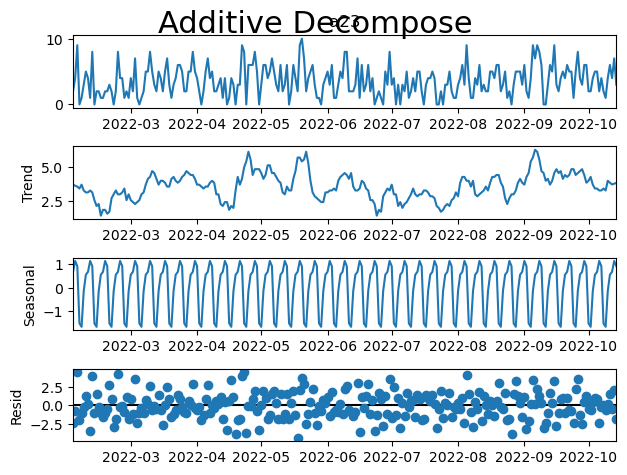

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
#result_mul = seasonal_decompose(tdata, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(analysis3.df['a23'], model='additive', extrapolate_trend='freq')

# Plot
#plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()


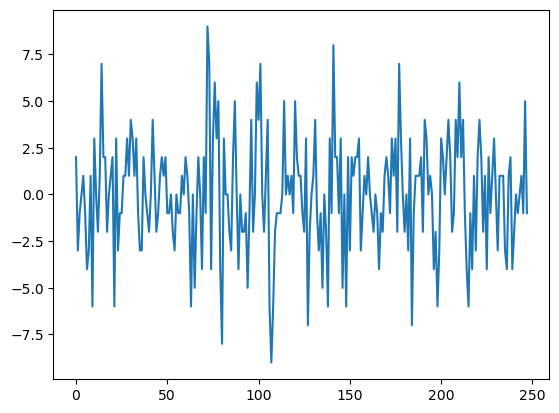

In [29]:
diff = list()
tdf = analysis3.df['a23'].values
days_in_year = 7
for i in range(days_in_year, len(tdf)):
 value = tdf[i] - tdf[i - days_in_year]
 diff.append(value)
pyplot.plot(diff)
pyplot.show()

In [9]:
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

import pmdarima as pm

C:\Users\kianv\AppData\Local\Temp\ipykernel_3696\3846794530.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [32]:
data = diff
model = pm.auto_arima(data, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
model.summary()

n_periods = 24
fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1245.826, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1247.237, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1244.373, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1244.999, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1245.439, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1240.274, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1241.877, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1247.111, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1247.028, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1242.271, Time=0.07 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 0.971 seconds


TypeError: 'builtin_function_or_method' object is not subscriptable

In [62]:
from statsmodels.tsa.stattools import adfuller, kpss
result = kpss(analysis3.df['a23'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# Time Series Decomposition
df = np.log(analysis3.df['a23'].values)
result_mul = seasonal_decompose(df, model='additive', period = 7 )

# Deseasonalize
deseasonalized = df / result_mul.seasonal

# Plot
plt.plot(deseasonalized)



KPSS Statistic: 0.212935
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\kianv\AppData\Local\Temp\ipykernel_24248\2797631332.py:10: RuntimeWarning: divide by zero encountered in log
  df = np.log(analysis3.df['a23'].values)


ValueError: This function does not handle missing values

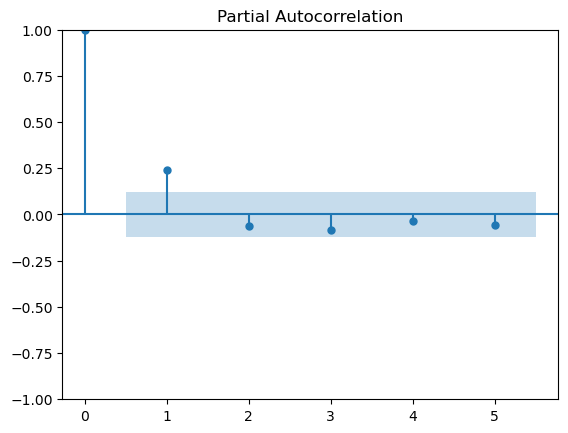

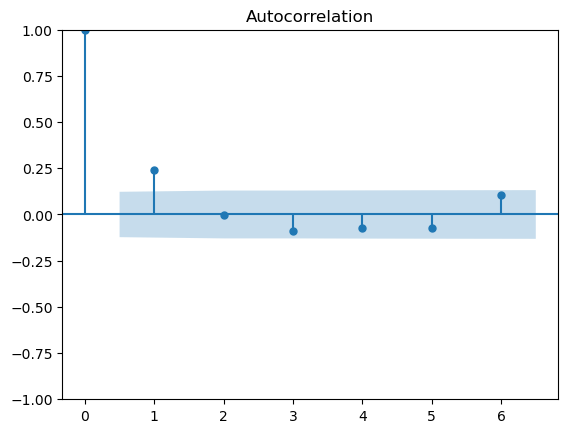

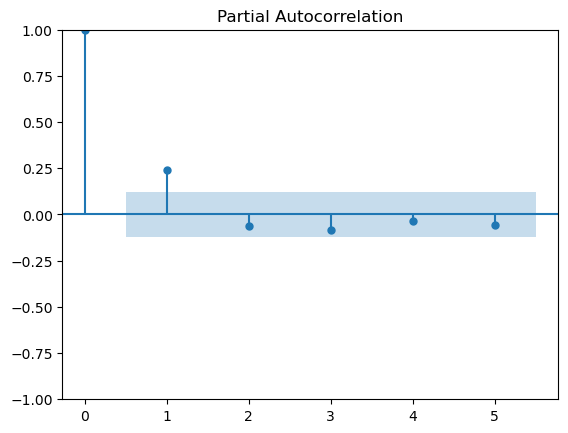

In [37]:
tdata = analysis3.df['a23'].values.tolist()
plot_acf(tdata,lags=6)
plot_pacf(tdata,lags = 5)

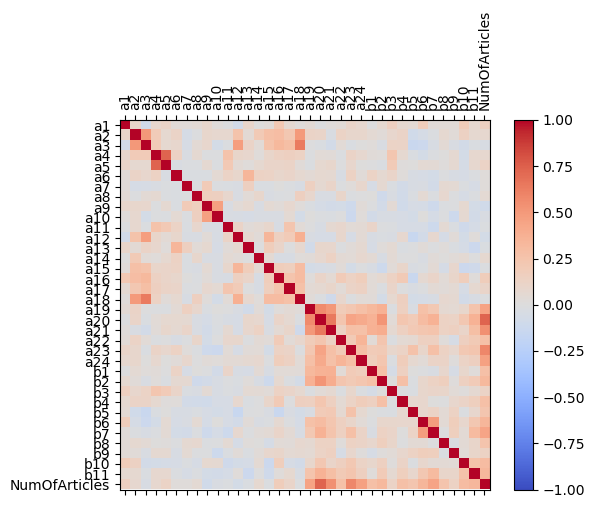

In [42]:
data = analysis3.df
corr = analysis3.df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

[1.00e-04 1.00e-04 0.00e+00 0.00e+00 1.00e-04 3.00e-04 1.00e-04 3.00e-04
 6.00e-04 3.00e-04 3.00e-04 8.00e-04 1.10e-03 9.00e-04 1.20e-03 1.30e-03
 2.10e-03 2.00e-03 2.80e-03 2.50e-03 3.80e-03 5.10e-03 4.10e-03 4.90e-03
 5.00e-03 6.70e-03 8.40e-03 8.30e-03 8.90e-03 1.10e-02 1.43e-02 1.39e-02
 1.44e-02 1.64e-02 1.69e-02 2.22e-02 2.11e-02 2.24e-02 2.45e-02 2.29e-02
 2.45e-02 2.77e-02 2.94e-02 2.75e-02 2.69e-02 2.75e-02 2.87e-02 3.28e-02
 3.02e-02 2.83e-02 3.13e-02 2.86e-02 3.01e-02 2.97e-02 2.66e-02 2.61e-02
 2.48e-02 2.17e-02 2.26e-02 2.03e-02 1.78e-02 1.86e-02 1.67e-02 1.76e-02
 1.31e-02 1.14e-02 1.20e-02 9.60e-03 8.60e-03 7.30e-03 8.60e-03 6.40e-03
 5.60e-03 5.20e-03 3.90e-03 3.80e-03 2.00e-03 2.50e-03 2.50e-03 2.10e-03
 1.20e-03 6.00e-04 8.00e-04 4.00e-04 1.00e-03 1.10e-03 5.00e-04 3.00e-04
 2.00e-04 2.00e-04 3.00e-04 2.00e-04 3.00e-04 0.00e+00 0.00e+00 1.00e-04
 0.00e+00 0.00e+00 1.00e-04]


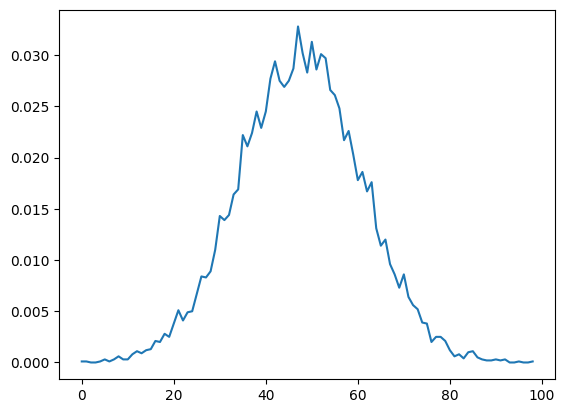

In [111]:
def monte_carlo_pdf_estimator(num_samples, sample_function,value):
    # Generate samples from the sample function
    samples = np.zeros(num_samples)
    for i in range(num_samples):
        samples[i] = sample_function()

    # Estimate the pdf by counting the occurrences of each value and normalizing
    bin_edges = np.linspace(np.min(samples), np.max(samples), num=100)
    hist, _ = np.histogram(samples, bins=bin_edges, density=True)
    pdf = hist / np.sum(hist)
    return(pdf)
def unif():
    return(np.random.normal())
dist = monte_carlo_pdf_estimator(10000,unif,-2)
print(dist)
plt.plot(dist)
#np.interp(0.75, x,y)

[-0.00013554 -0.00019916 -0.00042466 ... -0.0006911   0.0001452
  0.00014722]


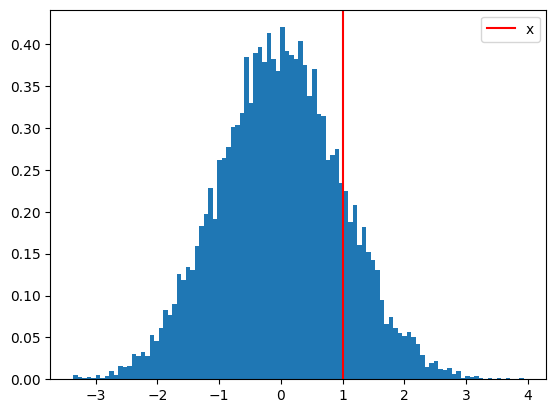

In [124]:
import numpy as np
import random
import matplotlib.pyplot as plt
def monte_carlo_probability_estimator(num_samples, sample_function, x):
    # Generate samples from the sample function
    global samples
    samples=  np.zeros(num_samples)
    for i in range(num_samples):
        samples[i] = sample_function()

    # Estimate the probability by counting the occurrences of x
    cdf = np.linspace(0, 1, len(samples))
    probability = np.mean(samples < x)
    pdf = np.gradient(cdf, samples)
    return pdf

# Define the sample function
def sample_function():
    return np.random.normal(0, 1)

# Define the value x
x = 1

# Run the Monte Carlo simulation
probability = monte_carlo_probability_estimator(10000, sample_function, x)
print(probability)
# Plot the results
plt.hist(samples, bins=100, density=True)
plt.axvline(x, color='red', label='x')
plt.legend()
plt.show()


In [127]:
import numpy as np

# Define the set of samples
samples = np.random.normal(0, 1, 10000)

# Define the specific sample
sample = 0

# Calculate the relative frequency of the specific sample
probability = np.sum(samples == sample) / len(samples)

print("The probability of the specific sample is:", probability)


The probability of the specific sample is: 0.0


In [129]:
import numpy as np

# Define the set of samples
samples = np.random.normal(0, 1, 10000)

# Define the specific sample
sample = 0

# Calculate the relative frequency of the specific sample
probability = np.sum(samples == sample) / len(samples)

print("The probability of the specific sample is:", probability)


The probability of the specific sample is: 0.0


In [87]:
list(range(9,-1,-1))

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

```analysis = Model()
filter = MonteCarlo(analysis)
for ID in list(analysis.df):
    filter.movingaveragemontecarlo(ID,2,2500)
    

In [89]:
analysis2 = Model()
filter2 = MonteCarlo(Model())
filter2.smc_smoother(observations= analysis2.df['a20'],transition_kernel= filter2.StateSpace_iplus1,observation_kernel= filter2.hiddenmodel_iplus1,num_steps=100,num_particles= 30)

Process our DataFrame:                   Successfully parsed and formatted our data
Process our Cumulative Probabilities DataFrame:     TEST-
                    Binomial Probabilities is the same as last row of cumulative probabilities
Process our DataFrame:                   Successfully parsed and formatted our data
Process our Cumulative Probabilities DataFrame:     TEST-
                    Binomial Probabilities is the same as last row of cumulative probabilities


C:\Users\kianv\AppData\Local\Temp\ipykernel_2760\3567369889.py:190: RuntimeWarning: invalid value encountered in scalar divide
  smoothed_weights[i, j] = weights[step, i] * backward_kernel[i, j] / np.dot(backward_kernel[:, j], weights[step, :])


array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [12.288036  , 10.06780218, 13.24859548, ..., 10.33969605,
        10.54145199, 10.33969605]])

In [ ]:
analysis = Model()
df = analysis.df
#analysis.MA_binomest_CI_plot('a5')
#analysis.CI_of_estimates_plot()
#analysis.binplot2()

In [36]:
def clopper_pearson(x, n, alpha=0.05):
    """Estimate the confidence interval for a sampled Bernoulli random
    variable.
    `x` is the number of successes and `n` is the number trials (x <=
    n). `alpha` is the confidence level (i.e., the true probability is
    inside the confidence interval with probability 1-alpha). The
    function returns a `(low, high)` pair of numbers indicating the
    interval on the probability.
    """
    
    b = scipy.stats.beta.ppf
    lo = b(alpha / 2, x, n - x + 1)
    hi = b(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi

from FunctionFile import * 

In [205]:
#Create a dataframe that computes the cumulative probability up until that date of a keyword occuring
cumprob = df.copy()

for column in list(cumprob)[:-1]:
    cumprob[column] = [sum(cumprob[column][:i+1])/sum(cumprob['NumOfArticles'][:i+1]) for i in range(0,len(cumprob[column]))]
cumprob['NumOfArticles'] =np.cumsum(cumprob['NumOfArticles'])

#Compute Binomial Estimates
binomestimates = [sum(df[column])/sum(df['NumOfArticles']) for column in list(df)[:-1]]

#Check that estimates line up with cumulative probaiblities at the end of the dataframe
for i in range(0,len(cumprob.iloc[-1][:-1])):
    if (cumprob.iloc[-1][:-1][i] != binomestimates[i]):
        print(False)
        break
    if i == len(cumprob.iloc[-1][:-1])-1:
        print("Binomial Probabilities is the same as last row of cumulative probabilities")
    

#TEST is valid.


Binomial Probabilities is the same as last row of cumulative probabilities


<Figure size 1600x1600 with 0 Axes>

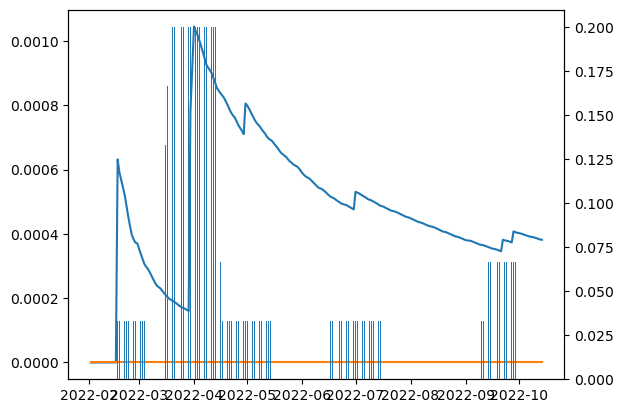

In [239]:
movingaverage(data, 'd5', 30, 0.05)

In [240]:
cols = list(cumprobdata)
cols = cols[1:-1]
cols
p = []
for ID in cols:
    p.append(cumprobdata.tail(1)[ID])

In [241]:
lot = []
hit = []
for i in p:
    successes = i*len(cumprobdata)
    total = len(cumprobdata)
    lo, hi = clopper_pearson(successes, total)
    lot.append(lo[0])
    hit.append(hi[0])
y=[]
for i in range(len(p)):
    y.append((lot[i],hit[i]))
x = [i for i in range(len(cols))]
plt.scatter(x,p, s = 10)
plt.plot((x,x),([i for (i,j) in y], [j for (i,j) in y]),c='black')
plt.show()
#remember to define p first!

def binplot(df):
    cols = list(df)[0:-1]
    hi = []
    k = 0 
    for ID in cols: 
        hi.append(kstest(df[ID], 'norm'))
        myarray = df[ID]
        weights = np.ones_like(myarray) / len(myarray)
        plt.hist(myarray, weights=weights)

        n = len(data)
        # defining list of r values
        r_values = list(range(0,30))
        # list of pmf values
        dist = [binom.pmf(r, n, p[k]) for r in r_values ]
        # plotting the graphs
        fg = Figure()
        ax = fg.gca()
        plt.plot(r_values, dist)
        plt.ylabel(ID)
        plt.xlabel(str(p[k]*len(data)))
        print(p[k])
        plt.show()
        k+=1
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    return(hi)

In [246]:
#remember to define p first!

def binplot2(df):
    cols = list(df)[0:-1]
    hi = []
    k = 0 
    for ID in cols: 
        hi.append(kstest(df[ID], 'norm'))
        myarray = df[ID]
        weights = np.ones_like(myarray) / len(myarray)
        plt.hist(myarray, weights=weights)
        p_hat = np.mean(myarray)/len(myarray)
        n = len(data)
        # defining list of r values
        r_values = list(range(0,30))
        # list of pmf values
        dist = [binom.pmf(r, n, p_hat) for r in r_values ]
        # plotting the graphs
        fig, ax = plt.subplots()
        plt.plot(r_values, dist)
        plt.ylabel(ID)
       # plt.xlabel(str(p[k]*len(data)))#list index out of range!!!
        #print(p[k])
        k+=1
        plt.savefig("hist" + ID+'.png')
    return(hi)

C:\Users\kianv\AppData\Local\Temp\ipykernel_18556\2860582045.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


[KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=

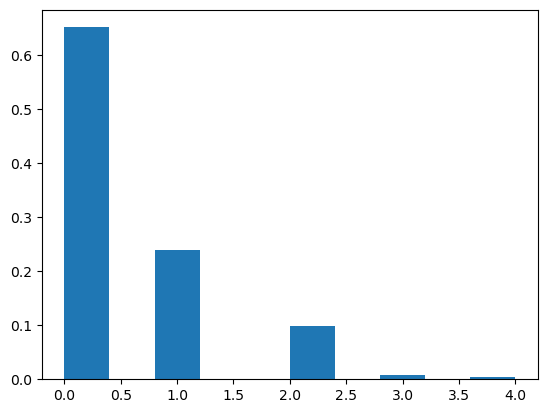

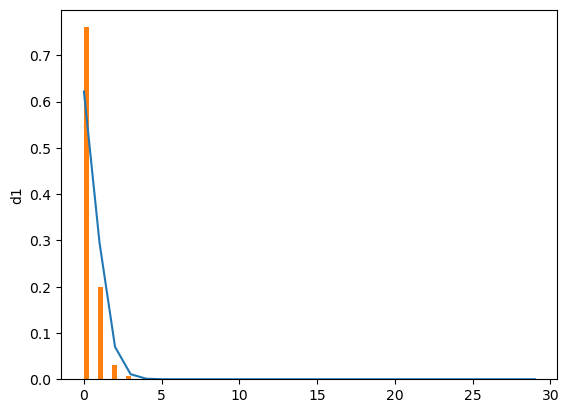

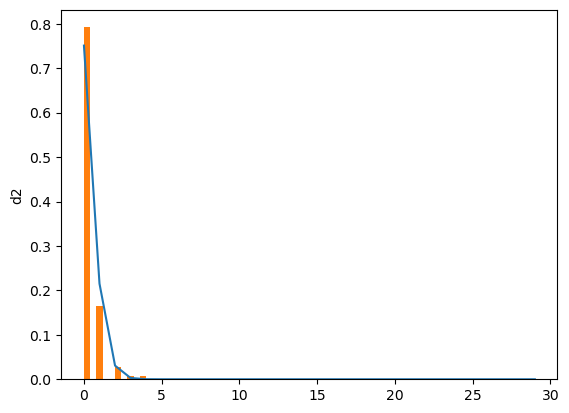

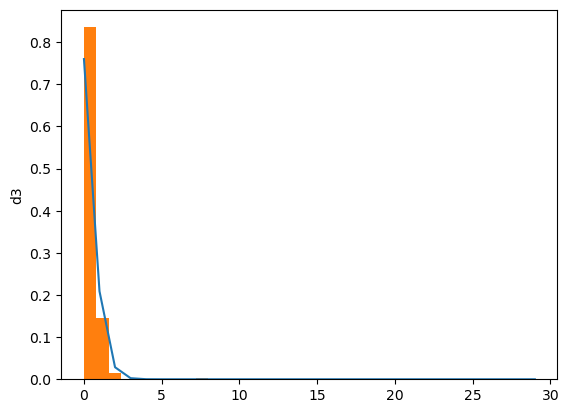

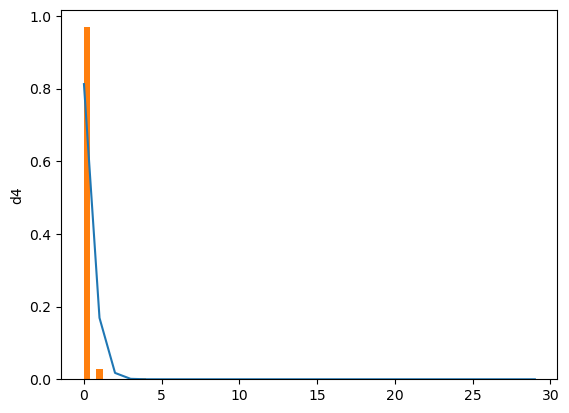

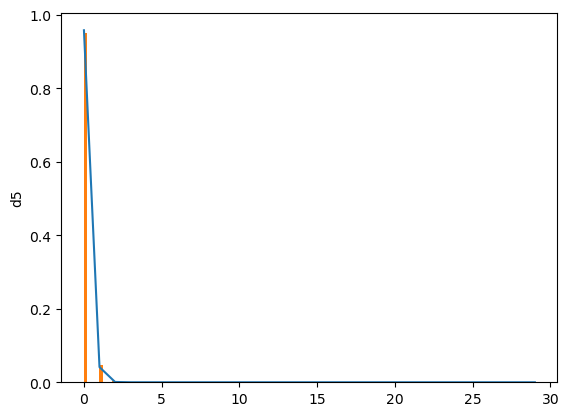

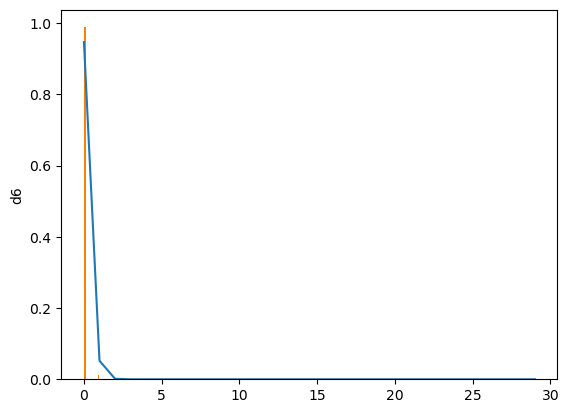

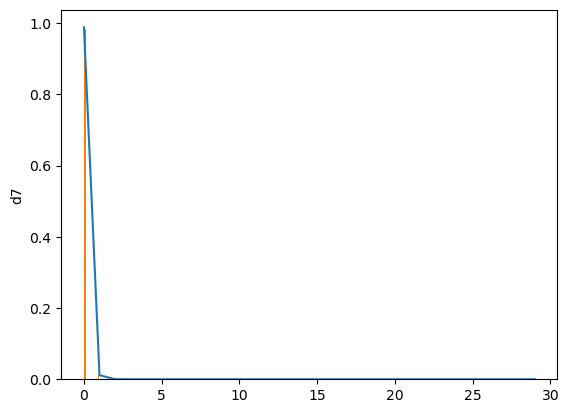

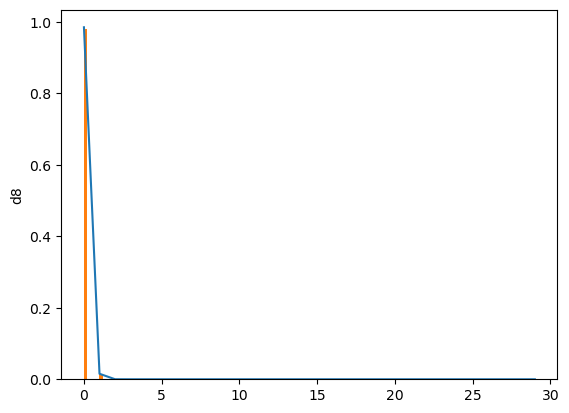

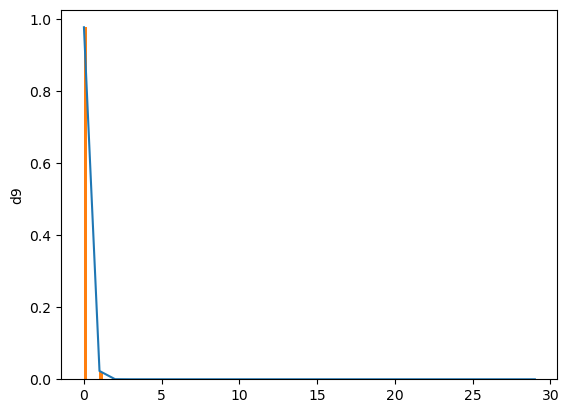

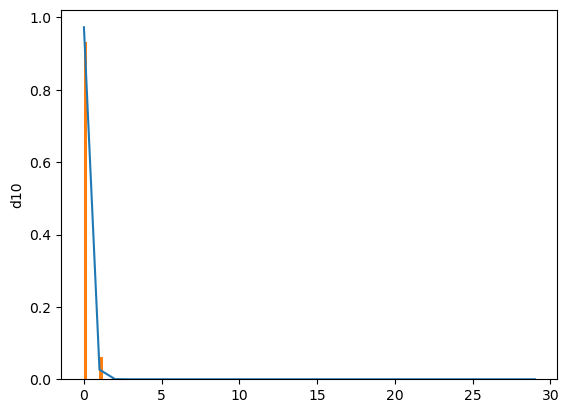

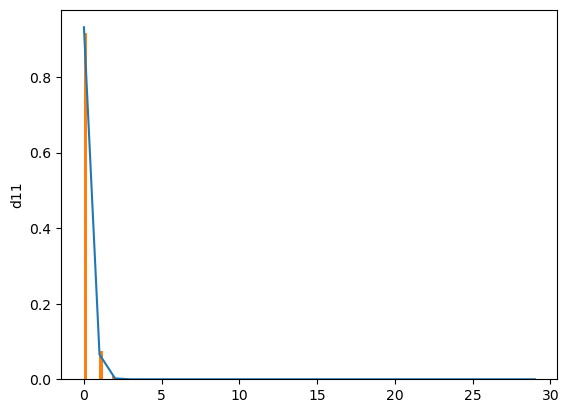

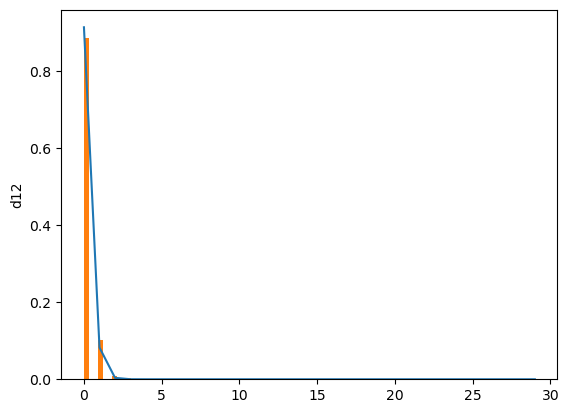

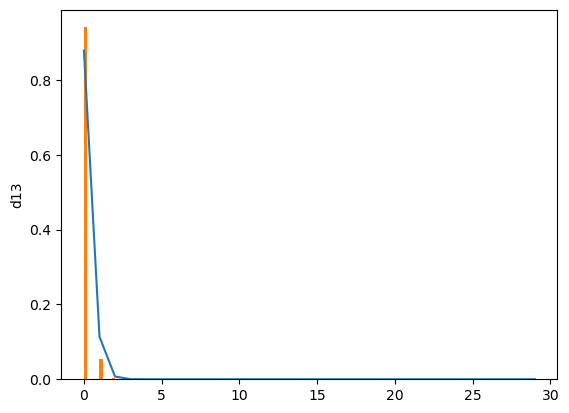

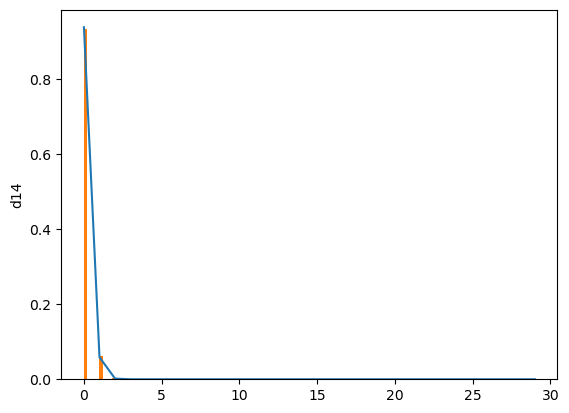

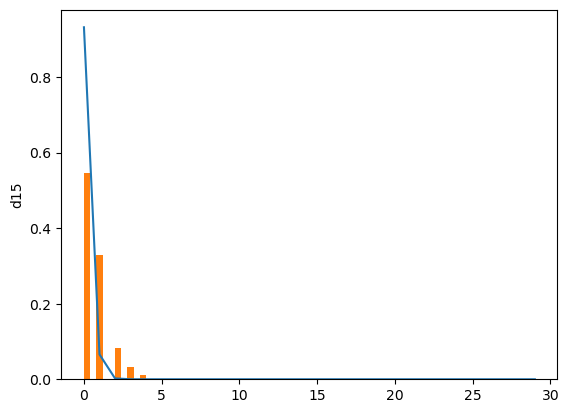

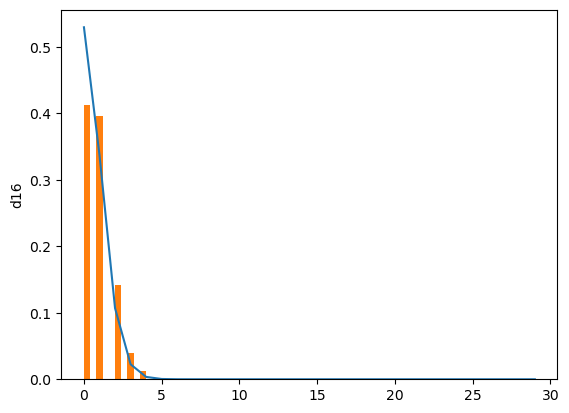

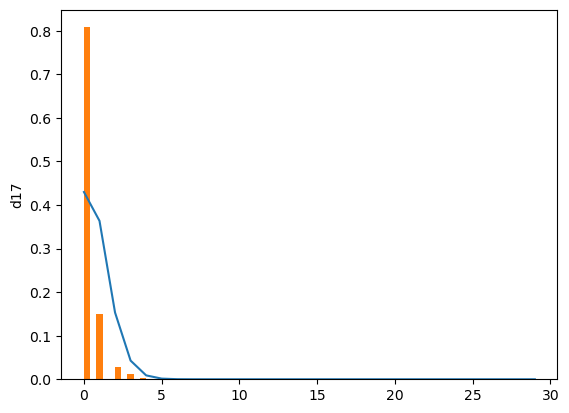

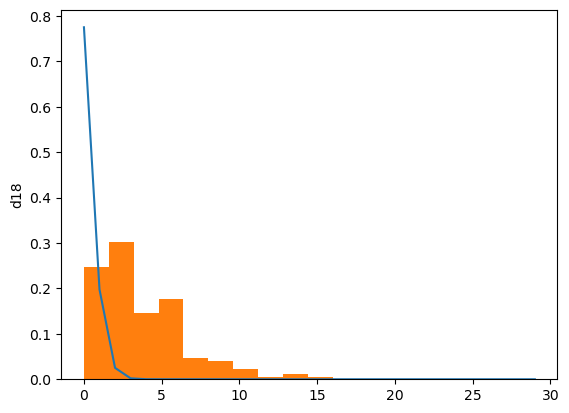

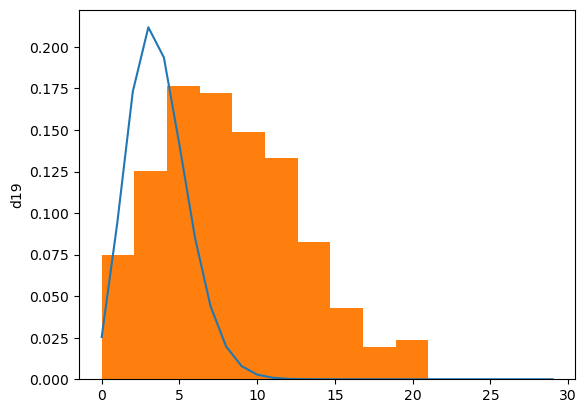

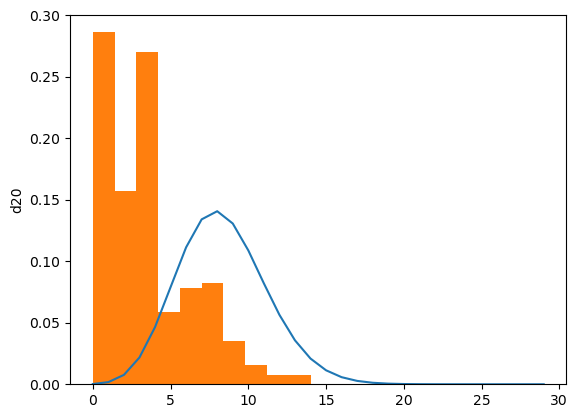

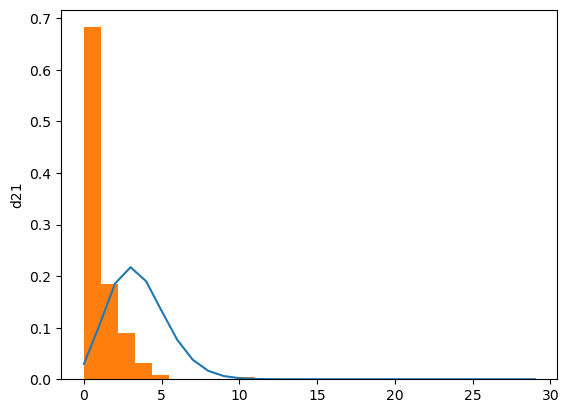

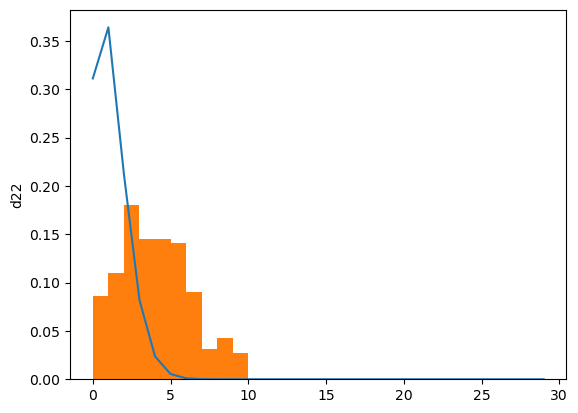

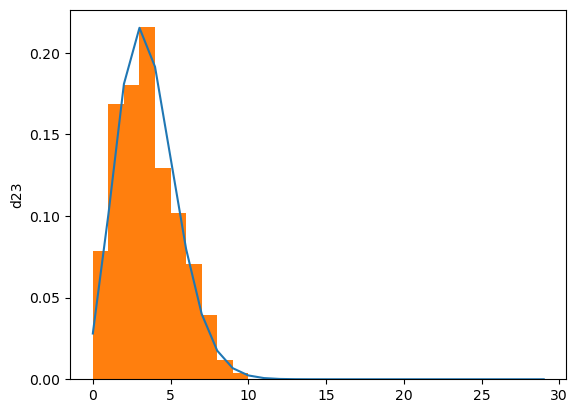

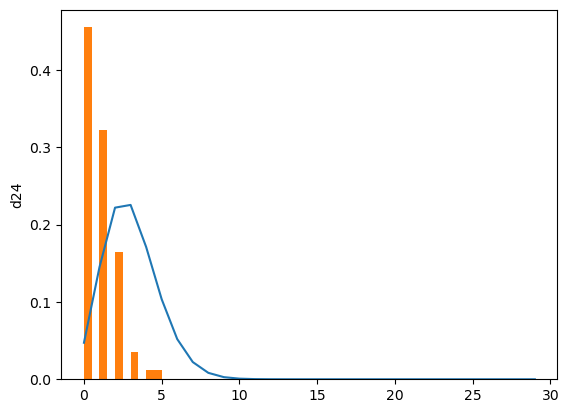

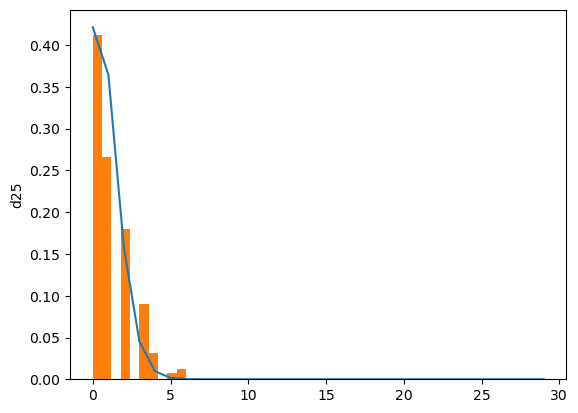

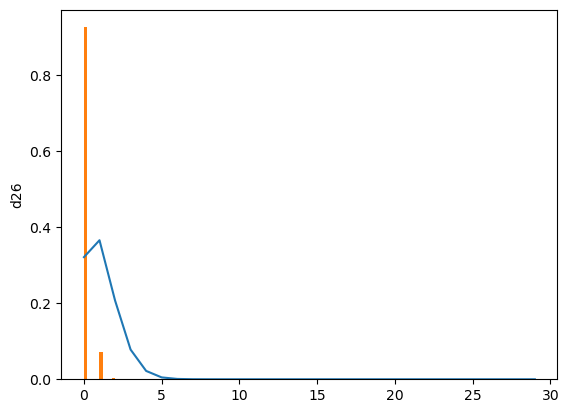

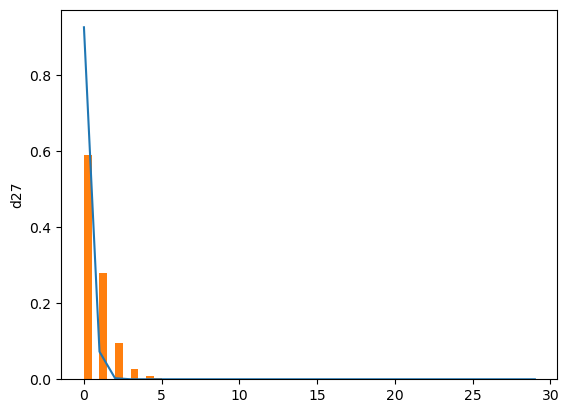

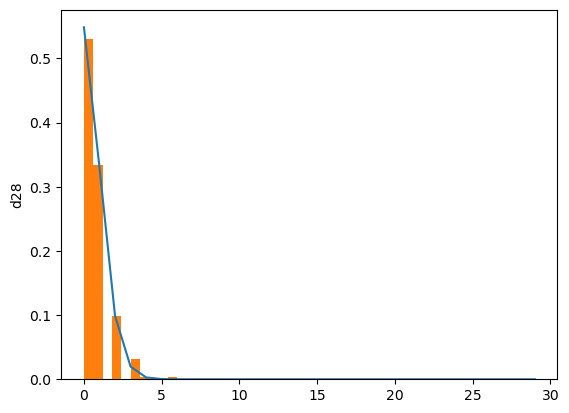

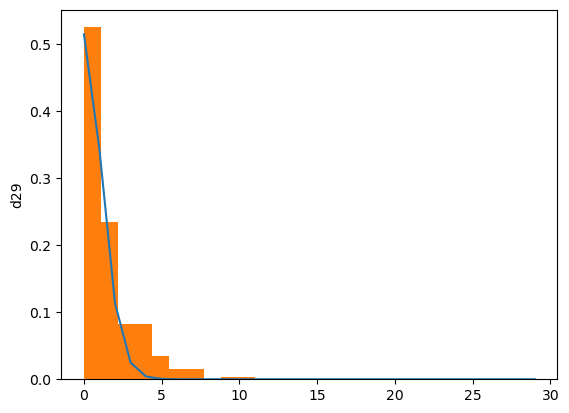

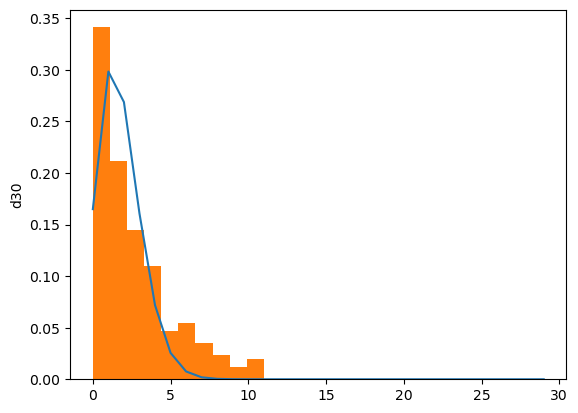

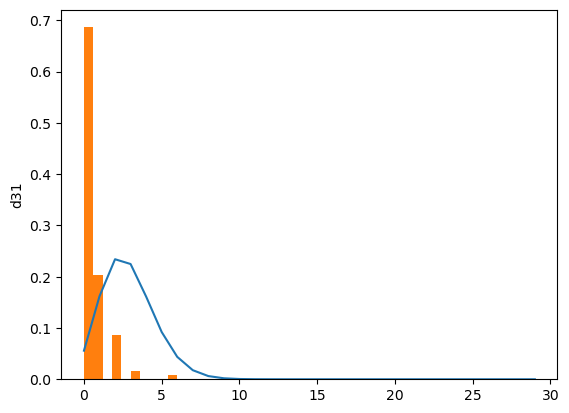

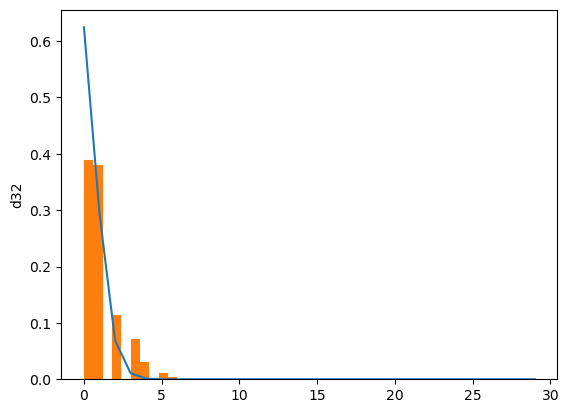

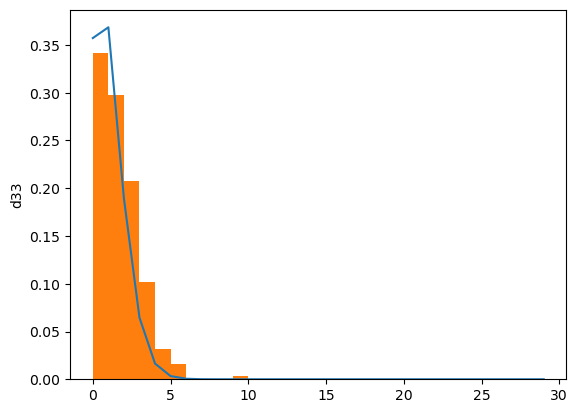

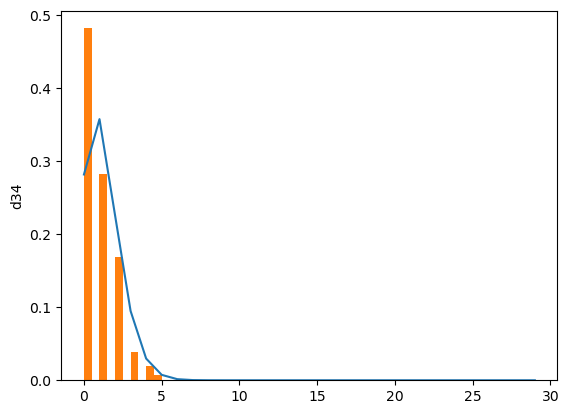

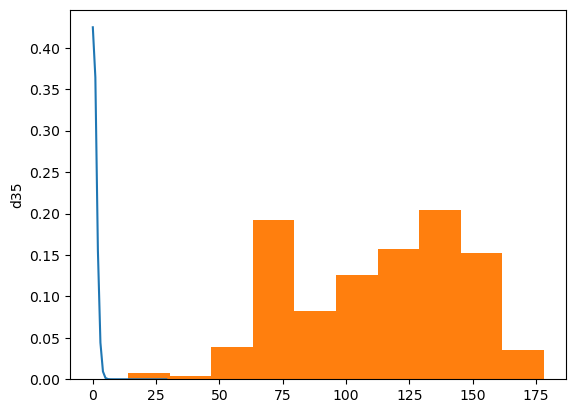

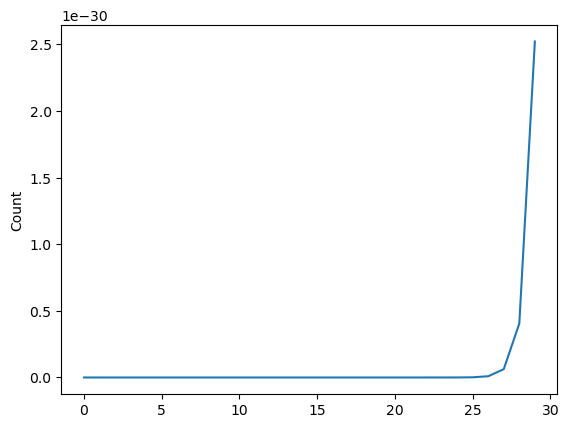

In [247]:
binplot2(data)

In [248]:
from scipy.stats import poisson

In [249]:
x0 = np.random.uniform()

In [250]:
def Xtplus1(Xt_1):
    return(Xt_1*np.random.uniform(low = 0.8, high = 1.2))

def Wt(Yt,Xt):
    return(poisson.pmf(Yt, mu=Xt))

Need to find dataframe that stipulates the probabilities!

In [251]:
probdata = pd.DataFrame()
cols = list(data)
cols = cols[:-2]
for ID in cols:
    probdata[ID] = data[ID]/data['Count']

We can now specify the pmf. i.e. Y - probdata[ID}.values

In [252]:
def multinomial_resample(weights):
    """ This is the naive form of roulette sampling where we compute the
    cumulative sum of the weights and then use binary search to select the
    resampled point based on a uniformly distributed random number. Run time
    is O(n log n). You do not want to use this algorithm in practice; for some
    reason it is popular in blogs and online courses so I included it for
    reference.
   Parameters
   ----------
    weights : list-like of float
        list of weights as floats
    Returns
    -------
    indexes : ndarray of ints
        array of indexes into the weights defining the resample. i.e. the
        index of the zeroth resample is indexes[0], etc.
    """
    cumulative_sum = np.cumsum(weights)
    #cumulative_sum[-1] = 1.  # avoid round-off errors: ensures sum is exactly one
    return np.searchsorted(cumulative_sum, random(len(weights)))

In [253]:
import numpy as np
from numpy.random import random

def resample(weights):
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1  # avoid round-off errors: ensures sum is exactly one
    return np.searchsorted(cumulative_sum, np.random(len(weights)))

def Filter(X,Yobs,N):
    W = [0 for i in range(N)]
    #Draw
    for i in range(N):
        #Draw/Mutation
        X[i] = Xtplus1(X[i]) #unif
        #Compute weights
        W[i] = Wt(Yobs,X[i])

    #Normalise weights
    sumW = sum(W)
    for i in range(N):
        W[i] = W[i]/sumW
        
    #Resample from these weights    

    I = multinomial_resample(W)
    
    #Convert to state space vectors
    I = np.array(I)
    X = np.array(X)
    X = X[I]
    
    X_est = sum(X)/N
        
    return(X,X_est)    

In [254]:
np.random.choice([1,2,3,4], size=4, replace=True, p=W)

ValueError: 'a' and 'p' must have same size

X0 = [np.random.uniform() for i in range(0,100)]
W = [0 for i in range(len(X0))]
Y = data['d2'].values

In [ ]:
N = 100
X0 = [np.random.uniform() for i in range(0,100)]
xstart = X0
rate =np.zeros(len(Y))
X=X0
for i in range(0,len(Y)):
    [X,X_est] = Filter(X,Y[i],N)
    rate[i] = X_est

In [14]:
def general_filter(Y,N,df,ID):
    d = np.array(df[ID])
    X0 = [np.mean(d) for i in range(0,N)]
    X = X0
    rate =np.zeros(len(Y))
    for i in range(0,len(Y)):
        [X,X_est] = Filter(X,Y[i],N)
        rate[i] = X_est
    return(rate)

In [18]:
df = analysis.df

In [20]:
#Draw values from initial distribution.
X0 = [np.random.uniform() for i in range(0,100)]
W = [0 for i in range(len(X0))]
Y = df['a2'].values
#Compute first weights
for i in range(0,len(X0)):
    W[i] = Wt(Y[0],X0[i])
for j in range(len(X0)):
    W[i] = W[i]/sum(W)


#for i in range(0,30):
#    X0,W = Filter(X0,W,Y)

NameError: name 'Wt' is not defined

In [21]:
general_filter()

TypeError: general_filter() missing 2 required positional arguments: 'df' and 'ID'

In [22]:
def Xtplus1(Xt_1):
    return(Xt_1*np.random.uniform(low = 0.8, high = 1.2))
    #return(Xt_1 *dnp.random.lognormal(mean=0.0, sigma=1.0)
    #return(Xt_1*np.random.exponential(scale = 1))
def Wt(Yt,Xt):
    return(poisson.pmf(Yt, mu=Xt))

In [25]:
def movingaveragemontecarlo(data,ID,K,N):
    p_est_dict = {}
    #changed plot to normal data
    vals = data[ID]
    df_dummy = df.copy()
    # p_est_array = np.array(Ksum(vals,K))/K
    rate = general_filter(df[ID],N,df,ID)
    
    #dfp.rolling(7, center=True).mean()
    hi = pd.DataFrame(vals)
    dude = pd.DataFrame(hi).rolling(K, center=True).mean()
    p_est_dict[ID] = dude[ID]
    p_est_array = dude[ID]
    
    hi = pd.DataFrame(df[ID])
    dude = pd.DataFrame(hi).rolling(K, center=True).mean()
    #return(d
    
    
    df_dummy['Plottingrate'] = rate
    
    figure(figsize=(10, 20), dpi=320)
    fig, ax = plt.subplots()
    #ax1.plot(df.index.values,df_dummy['Plottingrate'], color = 'red')
    #ax1.set_ylabel('SMC')
    
    #ax2 = ax1.twinx()
    #ax2.bar(df.index.values, dude[ID] ,width = 0.3)
    #ax2.set_ylabel('Moving Average')
    
    plt.plot(df.index.values,df_dummy['Plottingrate'], color = 'red')
    ax.bar(df.index.values, dude[ID] ,width = 0.3)
    
    #Ksum(df[ID].values,30)
    #
    #plt.plot(d0f.index.values, cumdata[ID])
    # ax1.plot(df.index.values,df_dummy['Plottingrate'], "r-")
    # ax1.ylabel('SMC')
    plt.title(ID)
    plt.savefig('new ' +ID+'.png')

Go through the documentaiton for this:
https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html 
Make sure that you are using the correct 

C:\Users\kianv\AppData\Local\Temp\ipykernel_18556\3830125349.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 20), dpi=320)


<Figure size 3200x6400 with 0 Axes>

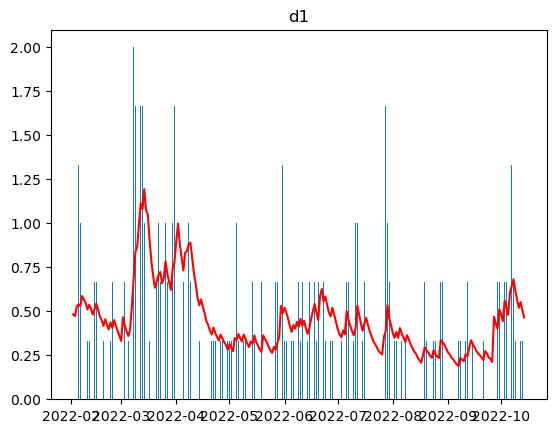

<Figure size 3200x6400 with 0 Axes>

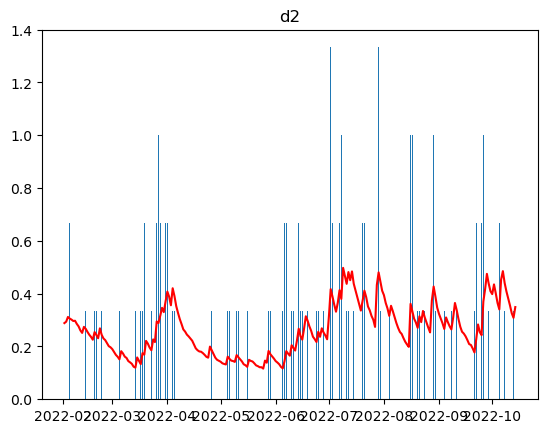

<Figure size 3200x6400 with 0 Axes>

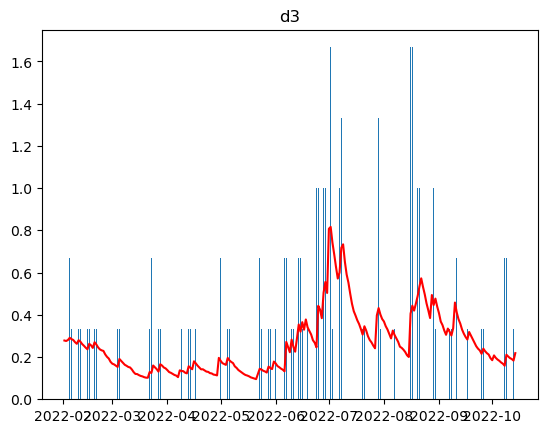

<Figure size 3200x6400 with 0 Axes>

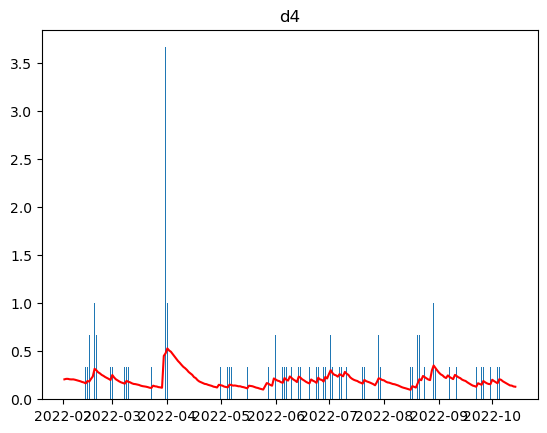

<Figure size 3200x6400 with 0 Axes>

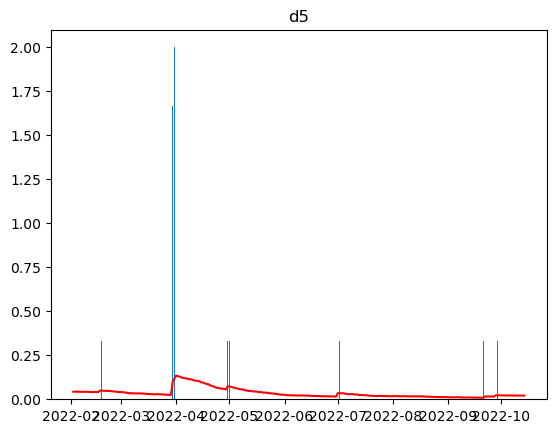

<Figure size 3200x6400 with 0 Axes>

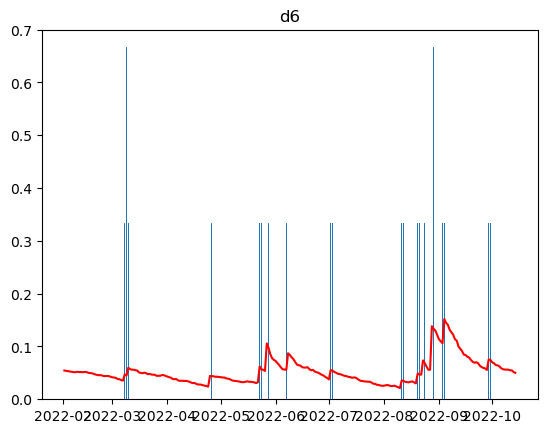

<Figure size 3200x6400 with 0 Axes>

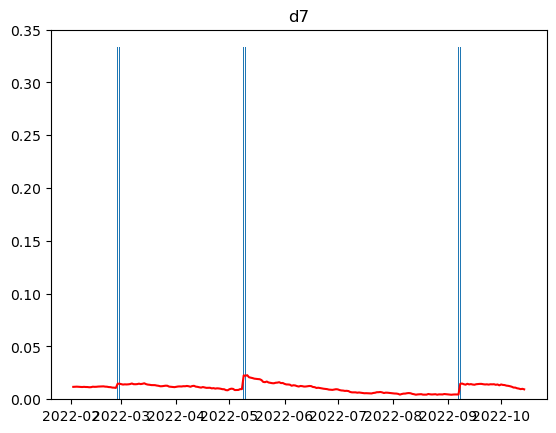

<Figure size 3200x6400 with 0 Axes>

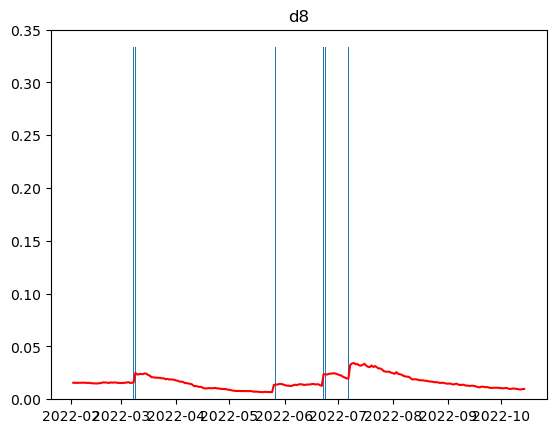

<Figure size 3200x6400 with 0 Axes>

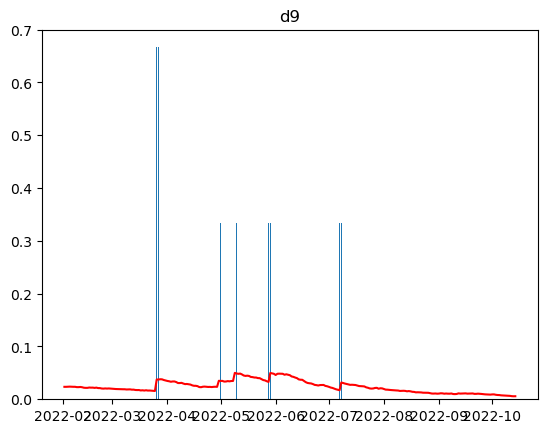

<Figure size 3200x6400 with 0 Axes>

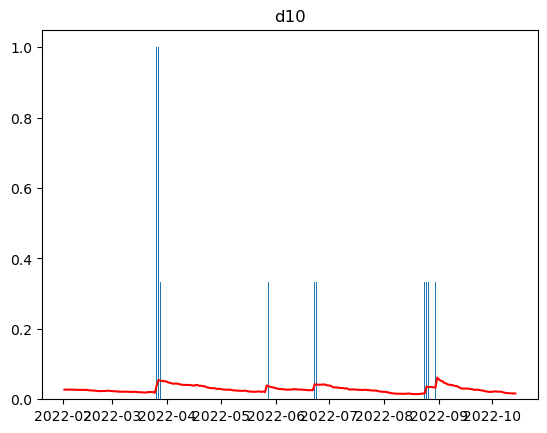

<Figure size 3200x6400 with 0 Axes>

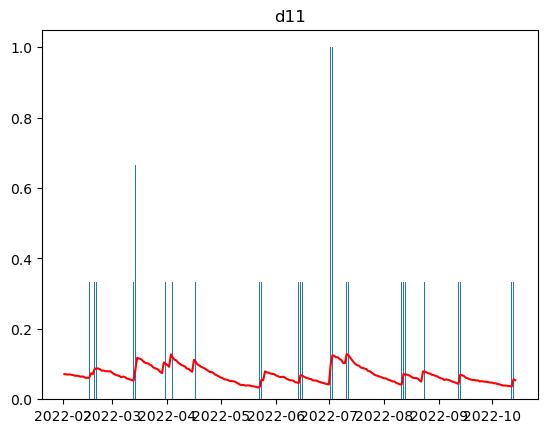

<Figure size 3200x6400 with 0 Axes>

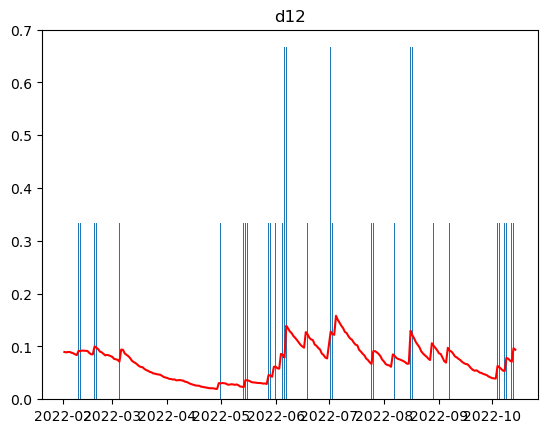

<Figure size 3200x6400 with 0 Axes>

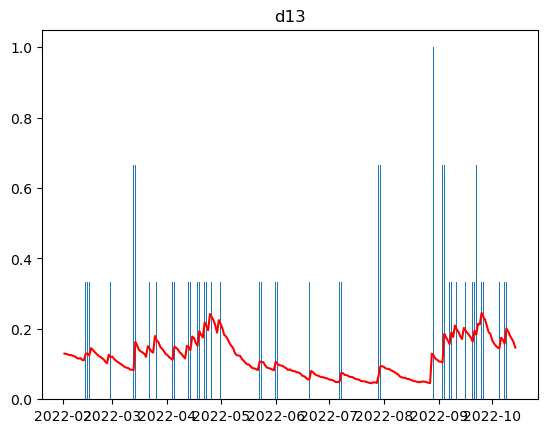

<Figure size 3200x6400 with 0 Axes>

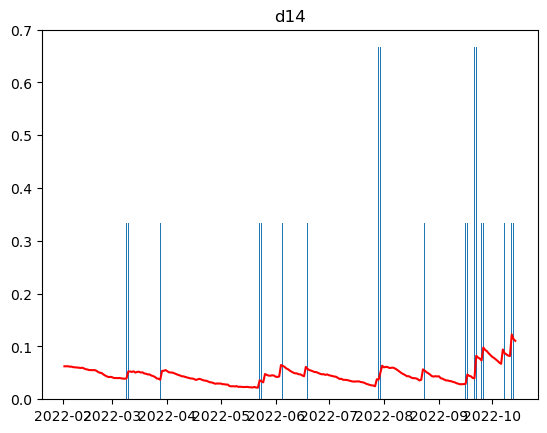

<Figure size 3200x6400 with 0 Axes>

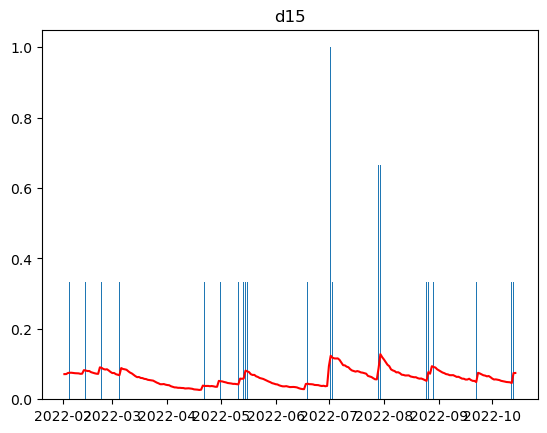

<Figure size 3200x6400 with 0 Axes>

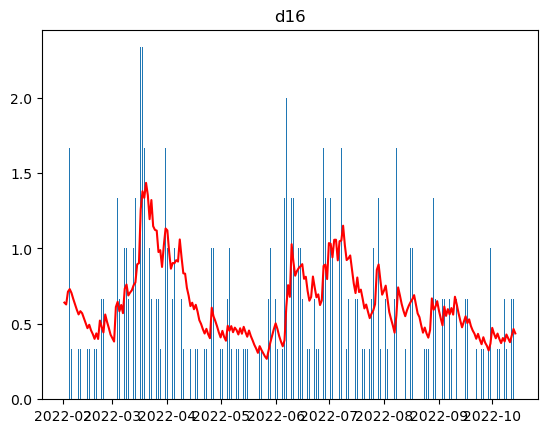

<Figure size 3200x6400 with 0 Axes>

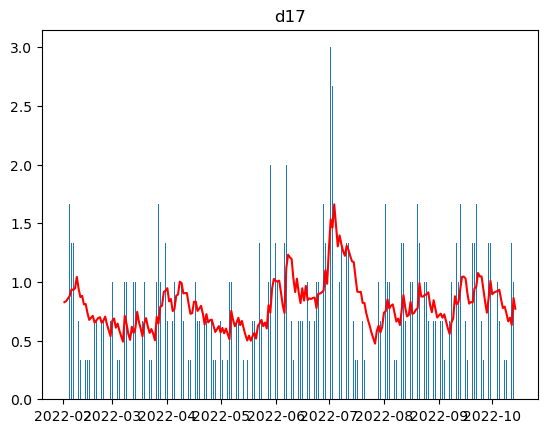

<Figure size 3200x6400 with 0 Axes>

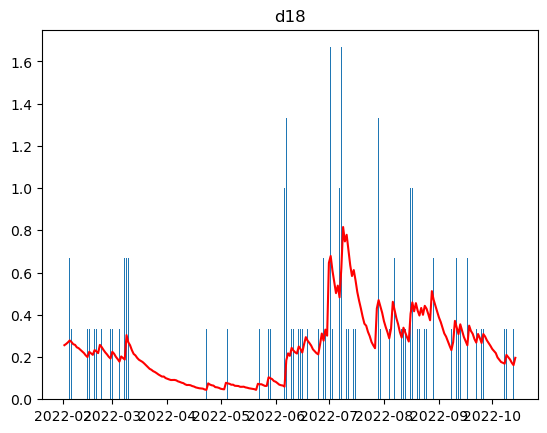

<Figure size 3200x6400 with 0 Axes>

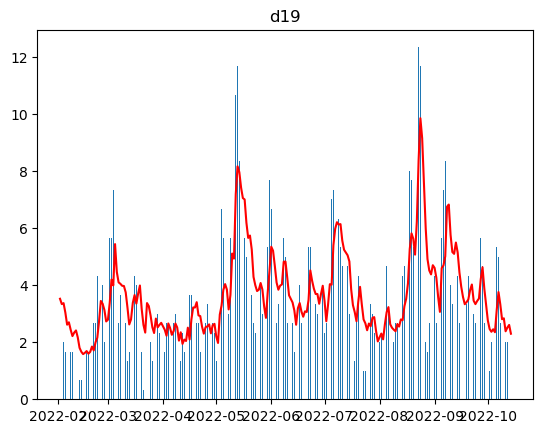

<Figure size 3200x6400 with 0 Axes>

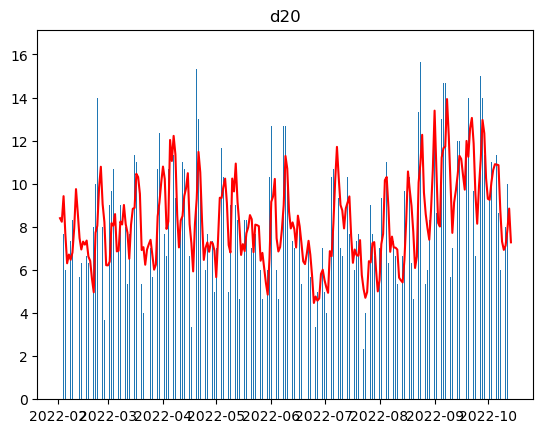

<Figure size 3200x6400 with 0 Axes>

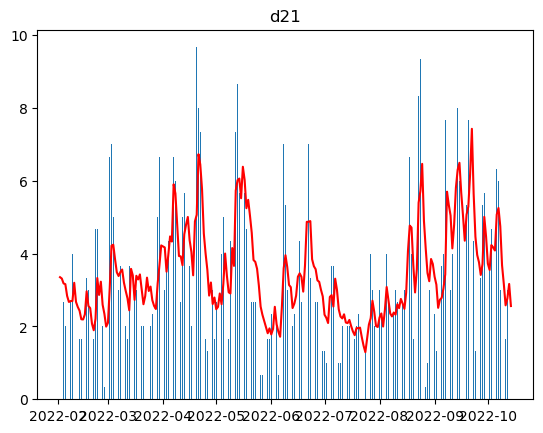

<Figure size 3200x6400 with 0 Axes>

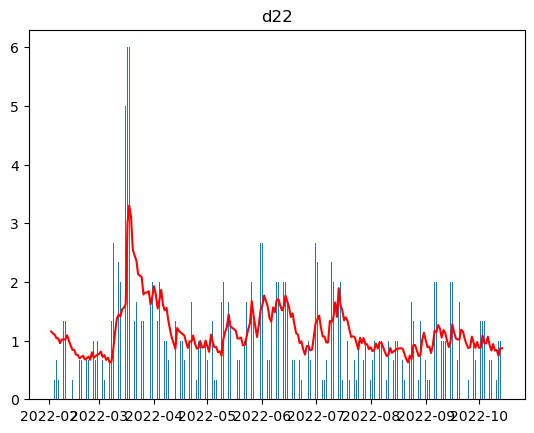

<Figure size 3200x6400 with 0 Axes>

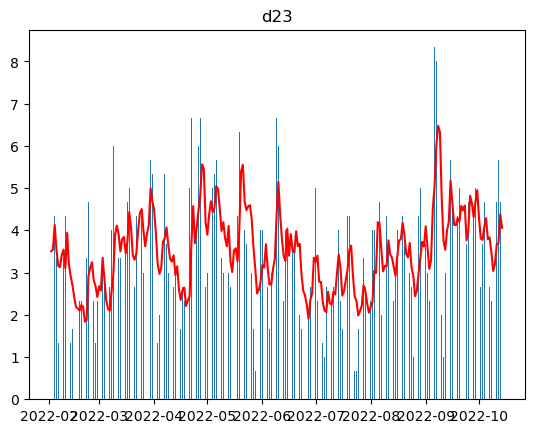

<Figure size 3200x6400 with 0 Axes>

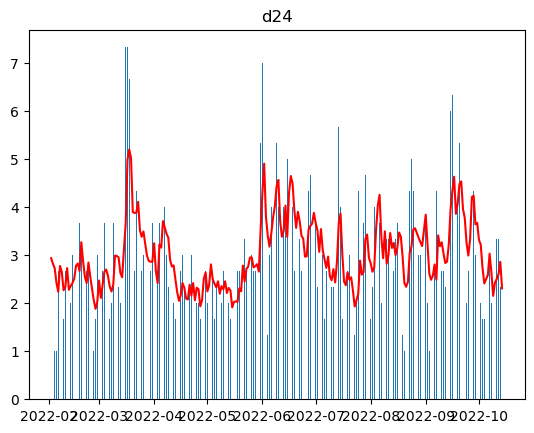

In [101]:
cols = list(data)
cols = cols[0:-2]
for ID in cols:
    movingaveragemontecarlo(data,ID,3,1000)